In [1]:
import importlib
import gm_utils

importlib.reload(gm_utils)  # Forces Python to reload the updated gm_utils.py

from gm_utils import visualize_density, sample, geodesic, energy
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm


In [2]:
# If latex is installed - for nicer formulas rendering in plots
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

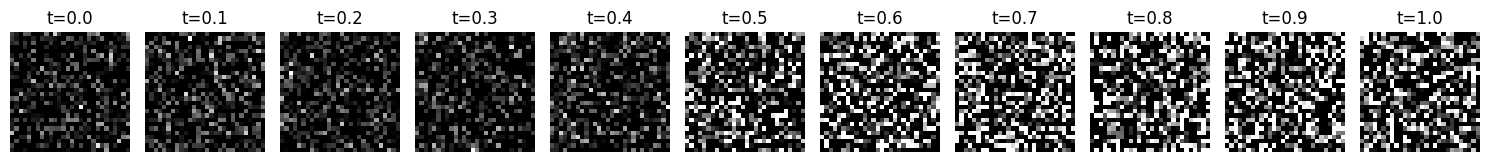

In [38]:
import torch
import matplotlib.pyplot as plt

# --- 1. Noise schedule (your function) ---
def alpha_sigma(t, T=1.0):
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values #-20,20


def log_SNR_cosine(t, s=0.008):
    """Cosine-shaped log-SNR schedule"""
    t_scaled = (t + s) / (1 + s)
    return torch.log(torch.tan(0.5 * torch.pi * (1 - t_scaled)))


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

# --- 2. Define clean image ---
# Black image (shape: C x H x W)
x0 = torch.zeros((1, 28, 28))

#x0 = torch.ones((1, 28, 28))

# --- 3. Define time steps ---
timesteps = torch.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0

# --- 4. Plot noisy images over time ---
plt.figure(figsize=(15, 2))
for i, t in enumerate(timesteps):
    # Compute schedule parameters
    alpha_t, sigma_t = alpha_sigma(t)

    # Sample Gaussian noise ε ~ N(0, I)
    eps = torch.randn_like(x0)

    # Compute x_t = α_t * x0 + σ_t * ε
    xt = alpha_t * x0 + sigma_t * eps

    # Plot
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(xt[0].clamp(0, 1), cmap='gray')
    plt.title(f"t={t:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Energy of pf ode trajectory: 0.9801619648933411 theta1 tensor([1., 1.])
theta2 tensor([0.1000, 0.3128])


100%|██████████| 1000/1000 [00:03<00:00, 272.52it/s]


Energy of a geodesic: 95.51589965820312
Energy of pf ode trajectory: 1.0629043579101562 theta1 tensor([1.0000, 0.2000])
theta2 tensor([0.1000, 0.0626])


100%|██████████| 1000/1000 [00:03<00:00, 255.65it/s]


Energy of a geodesic: 15.281102180480957
Energy of pf ode trajectory: 0.9801619648933411 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -0.3128])


100%|██████████| 1000/1000 [00:07<00:00, 130.98it/s]


Energy of a geodesic: 95.51589965820312


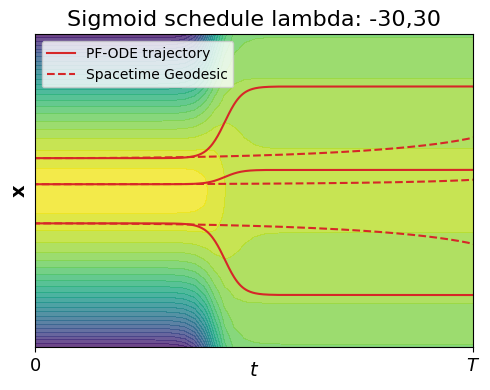

In [2]:
from curves import CubicSpline
import tqdm
import numpy as np
from scipy.interpolate import interp1d
import math 

x_points = np.array([0, 1, 2, 3])
y_points = np.array([0, 2, 4, 6])
f = interp1d(x_points, y_points)

from scipy.optimize import root_scalar
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

#original_means = torch.tensor([-0.5, 0.5], dtype=torch.float32) #0,0,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #1,0,0


original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.1, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)

#original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -30, 30 #min/max logSNR values #-20,20


def log_SNR_cosine(t, s=0.008):
    """Cosine-shaped log-SNR schedule"""
    t_scaled = (t + s) / (1 + s)
    return torch.log(torch.tan(0.5 * torch.pi * (1 - t_scaled)))



def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t



import torch

''' 
def alpha_sigma(t, T=1.0, Sigma0=0.0002, eps=1e-5):
    """
    Defines a forward diffusion process whose noise schedule satisfies:
        g²(t) = -Σ₀/T - 2 f(t) Σ₀ (1 - t/T)
    with f(t) = d/dt log α_t.
    """

    # Pick drift f(t)
    f_t = -0.5 / (T - t + eps)  # smooth drift

    # Integrate f_t -> α_t analytically
    alpha_t = torch.sqrt((T - t + eps) / (T + eps))
    sigma_t = torch.sqrt(1.0 - alpha_t**2)

    # Compute g²(t) according to relation
    g2_t = -Sigma0 / T - 2 * f_t * Sigma0 * (1.0 - t / T)

    # Optional: return g(t) for diagnostic
    g_t = torch.sqrt(torch.clamp(g2_t, min=0.0))

    return alpha_t, sigma_t
'''


def alpha_sigma_step(t, T=1.0, center=0.5, sharpness=100.0):
    """
    Forward process parameters for a VP SDE with a step-like noise schedule.
    
    Parameters
    ----------
    t : torch.Tensor
        Time values.
    T : float
        Total diffusion time.
    center : float
        Center of the step (between 0 and 1).
    sharpness : float
        Controls how steep the step is. Higher -> sharper jump.
    
    Returns
    -------
    alpha_t, sigma_t : torch.Tensor
        Scaling and noise coefficients.
    """
    # Sigmoid to create step-like sigma^2(t)
    sigma2_t = torch.sigmoid(sharpness * (t/T - center))
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    
    return alpha_t, sigma_t





def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t



def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t



def alpha_sigma(t, sigma_min=1e-2, sigma_max=5, T=1.0):
    """
    Forward process parameters for a Variance-Exploding (VE) SDE
    with a *linear-in-variance* schedule.
    
    sigma_t: standard deviation at time t
    alpha_t: kept for interface consistency, but equals 1 (no drift)
    """
    # Linearly increasing variance
    sigma2_t = sigma_min**2 + (sigma_max**2 - sigma_min**2) * (t / T)
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.ones_like(t)  # no decay of mean

    return alpha_t, sigma_t

def alpha_sigma(t, centers=(0.4, 0.6), sharpness=(500, 20), levels=(1.0, 0.6, 0)):
    """
    Variance-preserving schedule where alpha_t has three plateaus and two sharp drops.

    Args:
        t: torch.tensor in [0, 1]
        centers: positions of the two drops (c1, c2)
        sharpness: steepness of each drop (k1, k2)
        levels: plateau values of alpha (alpha_early, alpha_mid, alpha_late)
    Returns:
        alpha_t, sigma_t
    """
    c1, c2 = centers
    k1, k2 = sharpness
    a1, a2, a3 = levels

    # Two logistic transitions between plateaus
    s1 = torch.sigmoid(-k1 * (t - c1))  # from 1 → 0 at c1
    s2 = torch.sigmoid(-k2 * (t - c2))  # from 1 → 0 at c2

    # Combine transitions to create flat–drop–flat–drop–flat pattern
    alpha_t = a3 + (a2 - a3) * s2 + (a1 - a2) * s1

    # Variance preserving
    sigma_t = torch.sqrt(1 - alpha_t**2)
    return alpha_t, sigma_t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t



def compute_vector_field(x, t):
    """Implementation of the PF-ODE vector field"""
    alpha_t, sigma_t = alpha_sigma(t)
    f_t = 0.5 * (LAMBDA_MIN - LAMBDA_MAX) * sigma_t**2
    g2_t = (LAMBDA_MAX - LAMBDA_MIN) * sigma_t**2
    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    
    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()

def sample(x, n_steps, t_start=1, t_end=0):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)

def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x




def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm.tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def score_function(x, t):
    """Gradient of log p_t(x) w.r.t. x (the score)."""
    x = torch.tensor([x], dtype=torch.float32, requires_grad=True)
    t = torch.tensor([t], dtype=torch.float32)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x)[0]
    return grad_log_p_t.item()


import torch

def score_xt_given_x0(x0, xt, t):
    """
    Compute ∇_{x_t} log p(x0 | x_t).
    
    Parameters
    ----------
    x0 : torch.Tensor
        Ground-truth x0 (shape (B,) or scalar).
    xt : torch.Tensor
        Noisy sample at time t (shape (B,) or scalar).
    t : torch.Tensor or float
        Time(s) in [0,1].
    
    Returns
    -------
    score : torch.Tensor
        Gradient wrt x_t, same shape as xt.
    """
    # ensure tensors
    x0 = torch.as_tensor(x0, dtype=torch.float32)
    xt = torch.as_tensor(xt, dtype=torch.float32)
    t = torch.as_tensor(t, dtype=torch.float32)

    # get α_t, σ_t
    alpha_t, sigma_t = alpha_sigma(t)
    sigma2_t = sigma_t**2

    # gradient wrt xt
    score = -(xt - alpha_t * x0) / sigma2_t
    return score



def find_fixed_points(t, x_min=-4, x_max=4, n_intervals=200):
    """
    Find roots of score_function(x, t) by scanning intervals
    and applying root_scalar.
    """
    xs = np.linspace(x_min, x_max, n_intervals)
    vals = [score_function(x, t) for x in xs]

    roots = []
    for i in range(len(xs)-1):
        if vals[i] == 0:
            roots.append(xs[i])
        elif vals[i] * vals[i+1] < 0:
            try:
                sol = root_scalar(lambda x: score_function(x, t), bracket=[xs[i], xs[i+1]])
                if sol.converged:
                    roots.append(sol.root)
            except ValueError:
                pass
    return np.array(roots)




def plot_ode_geodesics(points):

    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
        #theta2 = torch.tensor([0.9999, 3.5])
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


 
def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-1.5, 1.5, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        
    ax.contourf(T, X, (densities).reshape(X.shape), levels=25, cmap='viridis', alpha=0.8)

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))

ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('Sigmoid schedule lambda: -30,30', fontsize=16)
plt.tight_layout()
plt.show()

# Transferring paths from one manifold to the other

NameError: name 'alpha__new_sigma_new' is not defined

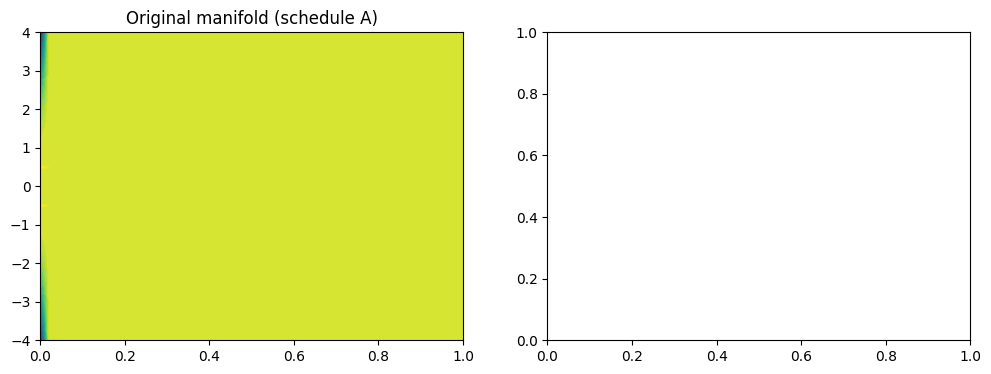

In [42]:
def log_SNR_cosine(t, s=0.008):
    """Cosine-shaped log-SNR schedule"""
    t_scaled = (t + s) / (1 + s)
    return torch.log(torch.tan(0.5 * torch.pi * (1 - t_scaled)))

def alpha_sigma_old(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


import torch
import math

def alpha_sigma_new(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t

def alpha_sigma_new(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(2*lambda_t).sqrt()
    sigma_t = torch.sigmoid(-2*lambda_t).sqrt()
    return alpha_t, sigma_t

def map_trajectory_to_new_schedule(x_t, t, alpha_sigma_old, alpha_sigma_new):
    """
    Map a trajectory (x_t, t) from one noise schedule to another.

    Args:
        x_t: torch.Tensor of shape (N,) -- original trajectory x values
        t: torch.Tensor of shape (N,) -- corresponding times
        alpha_sigma_old: function t -> (alpha, sigma) for old schedule
        alpha_sigma_new: function t -> (alpha, sigma) for new schedule

    Returns:
        x_t_new: torch.Tensor of shape (N,) -- trajectory under new schedule
    """
    # old schedule
    alpha_old, sigma_old = alpha_sigma_old(t)
    
    # compute EDS (denoised x0)
    x_t.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x_t, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x_t)[0]
    x0_hat = (x_t + sigma_old**2 * grad_log_p_t) / alpha_old

    # implied noise under old schedule
    eps = (x_t - alpha_old * x0_hat) / sigma_old

    # new schedule
    alpha_new, sigma_new = alpha_sigma_new(t)
    x_t_new = alpha_new * x0_hat + sigma_new * eps
    return x_t_new.detach()

# --- Example plotting function ---
def plot_transferred_trajectory(points, n_steps=512):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t_min = 0.1
    visualize_density(ax1)
    ax1.set_title("Original manifold (schedule A)")

    # Also visualize B's manifold
    def gaussian_density_B(x, t):
        alpha, sigma = alpha__new_sigma_new(t)
        means_t = alpha[:, None] * original_means[None, :]
        variances_t = sigma[:, None]**2 + alpha[:, None]**2 * original_variance
        log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
        return torch.logsumexp(log_probs, dim=1)

    n_time_points = 50
    n_space_points = 200
    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-4, 4, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    densities_B = gaussian_density_B(torch.from_numpy(X.flatten()), torch.from_numpy(T.flatten())).reshape(X.shape).detach()
    ax2.contourf(T, X, densities_B.numpy(), levels=20, cmap='viridis', alpha=0.9)
    ax2.set_title("Transferred manifold (schedule B)")

    # Loop over initial points
    for i, x0 in enumerate(points):
        # sample PF-ODE under old schedule
        t_vals_traj, x_vals_traj = sample(x0, n_steps, t_start=1., t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate([t_vals_traj, x_vals_traj], axis=1))

        # plot in original manifold
        ax1.plot(pf_ode_theta[:,0], pf_ode_theta[:,1], color='C3', label='PF-ODE' if i==0 else None)

        # map trajectory to new schedule
        x_t_new = map_trajectory_to_new_schedule(torch.from_numpy(x_vals_traj.flatten()), 
                                                 torch.from_numpy(t_vals_traj.flatten()), 
                                                 alpha_sigma_old, alpha_sigma_new)
        ax2.plot(t_vals_traj, x_t_new.numpy(), color='C3', label='Transferred PF-ODE' if i==0 else None)

    for ax in [ax1, ax2]:
        ax.set_xlim((t_min, 1))
        ax.set_xticks([t_min, 1], [r'$0$', r'$T$'])
        ax.set_yticks([])
        ax.set_xlabel(r'$t$', fontsize=14)
        ax.set_ylabel(r'$x$', fontsize=14)
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

# --- Call the plotting ---
plot_transferred_trajectory(torch.tensor([[1.], [0.], [-1]]))


# Diffusion

In [4]:
def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x


def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)

    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    #f = eds(t, x)
    f=res
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res


def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        #print('Jacobian eta:',J_eta,'Jacobian J_mu:', J_mu)
        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta  

original_means = torch.tensor([ 0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5
 #min/max logSNR values #-20,20


matrix, theta= metric_tensor_differentiable(torch.tensor([[0.5, 0.5]]))
print('determinant matrix', torch.det(matrix))


print(eta(torch.tensor([[0.95, 0.2]])))
print(eta(torch.tensor([[0.1, 0.2]])))

print('mu',mu(torch.tensor([[0.95, 0.2]])))
print(mu(torch.tensor([[0.1, 0.2]])))

#print('metric',metric_tensor(torch.tensor([[0.5, 0.5]])))
#print(metric_tensor(torch.tensor([[0.5, -0.5]])))

print('metric dif', metric_tensor_differentiable(torch.tensor([[0.5, 0.3]])))


#print('gaussian curvature 2d', gaussian_curvature_2d(torch.tensor([[0.4, 0.54]])))

#print(sectional_curvature(torch.tensor([[-0.5, 0.5]])))

#print(gaussian_curvature(torch.tensor([[0.2, 0.356]])))



determinant matrix tensor([0.0113], grad_fn=<LinalgDetBackward0>)
(tensor([-1.4940e-07]), tensor([0.0001]))
(tensor([-9197.5361]), tensor([3679.1145]))
mu (tensor([0.], grad_fn=<AddBackward0>), tensor([0.], grad_fn=<DivBackward0>))
(tensor([0.0400], grad_fn=<AddBackward0>), tensor([0.2000], grad_fn=<DivBackward0>))
metric dif (tensor([[[ 0.2399, -0.1125],
         [-0.1125,  0.0998]]], grad_fn=<CopySlices>), tensor([[0.5000, 0.3000]], requires_grad=True))


det min: 1.4488062138884317e-10
det max: 2309.79345703125


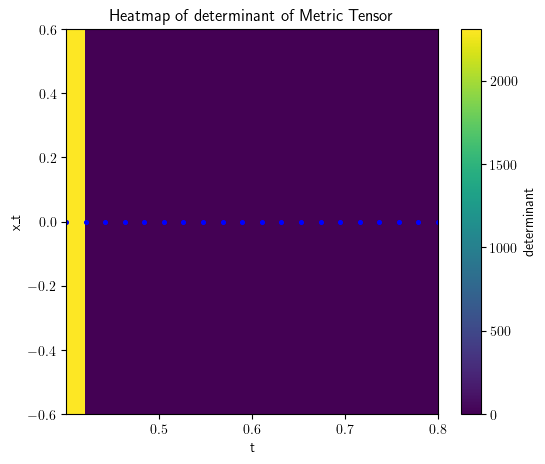

In [5]:
'''
Heatmap of the determinant of the metric tensor
'''


#original_means = torch.tensor([ -1.5, -0.25, 0, 0.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5], dtype=torch.float32)  #1,0,0 #1,1,0

#original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.1, dtype=torch.float32) #0.4
#weights = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float32) 

#original_means = torch.tensor([ -1.5, -1.25, 0, 1.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5], dtype=torch.float32)  #1,0,0 #1,1,0


LAMBDA_MIN, LAMBDA_MAX = -5, 5

t_vals = torch.linspace(0.4, 0.8, 20)
xt_vals = torch.linspace(-0.6, 0.6, 20)
det_values = torch.zeros(len(t_vals), len(xt_vals))


for i, t in enumerate(t_vals):
    for j, xt in enumerate(xt_vals):
        matrix, A = metric_tensor_differentiable(torch.tensor([[t, xt]]))
        det_values[i, j] = torch.det(matrix)

det_values = det_values.detach().numpy() 

det_values = np.array(det_values, dtype=float)

print("det min:", det_values.min())
print("det max:", det_values.max())

# Use seaborn for a nice heatmap
fixed_points = []

for t in t_vals:
    roots = find_fixed_points(t)
    for r in roots:
        fixed_points.append((t, r))

fixed_points = np.array(fixed_points)

plt.figure(figsize=(6,5))
plt.imshow(det_values.T,
           extent=[t_vals.min().item(), t_vals.max().item(),
                   xt_vals.min().item(), xt_vals.max().item()],
           origin='lower',
           aspect='auto',
           cmap='viridis',
           vmin=det_values.min(),   # colorbar starts at min determinant
           vmax=det_values.max())
plt.colorbar(label="determinant") 
plt.scatter(fixed_points[:, 0], fixed_points[:, 1], color='blue', s=7, label="Critical points")

plt.xlabel("t")
plt.ylabel("x_t")
plt.title("Heatmap of determinant of Metric Tensor")
plt.show()


tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


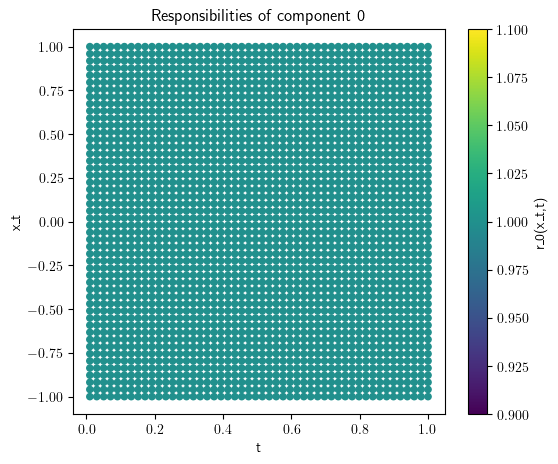

In [6]:
import torch
import matplotlib.pyplot as plt



#original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.001, dtype=torch.float32) #0.4
#weights = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float32)
LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values #-20,20#min/max logSNR values #-20,20


def responsibilities(x, t, means, variance, weights):
    """
    Compute responsibilities r_k(x_t, t) for 1D Gaussian mixture prior.
    
    -------
    r : torch.Tensor, shape (N,K)
    """
    alpha_t, sigma_t = alpha_sigma(t)            
    var_t = sigma_t**2 + (alpha_t**2) * variance  

    x = x[:, None]
    alpha_t = alpha_t[:, None]
    var_t = var_t[:, None]
    means_t = alpha_t * means[None, :]  

    log_probs = torch.log(weights[None, :] + 1e-12) \
                - 0.5 * (torch.log(2 * torch.pi * var_t) \
                + (x - means_t)**2 / var_t)

    log_norm = torch.logsumexp(log_probs, dim=1, keepdim=True)
    r = torch.exp(log_probs - log_norm) 
    print(r)
    return r


def scatter_responsibilities(t_vals, x_vals, means, variance, weights, k=0):
    """
    Scatter plot of (t, x_t) colored by responsibility r_k(x_t,t).

    Parameters
    ----------
    t_vals : torch.Tensor of shape (N,)
        Times in (0,1).
    x_vals : torch.Tensor of shape (M,)
        Spatial positions (xt values).
    means, variance, weights : mixture params
    k : int
        Which component's responsibility to plot
    """
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")
    coords = torch.stack([T.flatten(), X.flatten()], dim=-1)

    r = responsibilities(X.flatten(), T.flatten(),
                         means, variance, weights)  # (N*M, K)
    r_k = r[:, k].detach().numpy()

    plt.figure(figsize=(6,5))
    sc = plt.scatter(T.flatten().numpy(), 
                     X.flatten().numpy(), 
                     c=r_k, cmap="viridis", s=20)
    plt.colorbar(sc, label=f"r_{k}(x_t,t)")
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.title(f"Responsibilities of component {k}")
    plt.show()


t_vals = torch.linspace(0.01, 1.0, 50)   # 50 time points
x_vals = torch.linspace(-1.0, 1.0, 50)   # restrict xt ∈ [-1,1]

scatter_responsibilities(t_vals, x_vals, 
                         original_means, original_variance, weights, k=0)
    # late t, responsibilities flatten


In [8]:
import torch
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
def responsibilities2(x, t, means, variance, weights):
    x = x.requires_grad_(True)
    t = t.requires_grad_(True)


    alpha_t, sigma_t = alpha_sigma(t)

    var_t = sigma_t**2 + (alpha_t**2) * variance

    x = x[:, None]           # (N,1)
    alpha_t = alpha_t[:, None]
    var_t = var_t[:, None]
    means_t = alpha_t * means[None, :]

    log_probs = torch.log(weights[None, :] + 1e-12) - 0.5 * (torch.log(2*torch.pi*var_t) + (x - means_t)**2 / var_t)
    log_norm = torch.logsumexp(log_probs, dim=1, keepdim=True)
    r = torch.exp(log_probs - log_norm)
    return r

# Laplace-Beltrami heatmap
def laplace_beltrami_heatmap(t_vals, x_vals, means, variance, weights, k=0):
    # Create grid
    T, X = torch.meshgrid(t_vals, x_vals, indexing='ij')
    coords = torch.stack([T.flatten(), X.flatten()], dim=-1).requires_grad_(True)

    # Compute responsibilities
    r = responsibilities2(coords[:,1], coords[:,0], means, variance, weights)
    r_k = r[:, k]  # (N*M,)

    # Metric tensor
    I_batch, coords_req = metric_tensor_differentiable(coords)
    eps = 1e-6
    g = I_batch + eps * torch.eye(2, device=I_batch.device).unsqueeze(0)
    g_inv = torch.linalg.inv(g)

    # Gradient of r_k
    grad_r = torch.autograd.grad(r_k.sum(), coords_req, create_graph=True)[0]  # (N*M,2)

    # Laplace-Beltrami: Δ_g r_k
    # Batched version
    gi_grad = torch.bmm(g_inv, grad_r.unsqueeze(-1)).squeeze(-1)  # (N*M,2)
    delta_r = torch.zeros_like(r_k)
    for i in range(2):
        grad_i = torch.autograd.grad(gi_grad[:, i].sum(), coords_req, create_graph=True)[0][:, i]
        if grad_i is None:
            grad_i = torch.zeros_like(coords_req)
        delta_r += grad_i[:, i]
        grad_i = torch.autograd.grad(gi_grad[:, i].sum(), coords_req, create_graph=True, allow_unused=True)[0]
       

    # Reshape and plot
    delta_r_np = delta_r.detach().cpu().numpy().reshape(len(t_vals), len(x_vals))
    plt.figure(figsize=(7,5))
    plt.imshow(delta_r_np, extent=[x_vals.min(), x_vals.max(), t_vals.min(), t_vals.max()],
               origin='lower', aspect='auto', cmap='coolwarm')
    plt.colorbar(label=f'Δ_g r_{k}(x_t,t)')
    plt.xlabel("x_t")
    plt.ylabel("t")
    plt.title(f"Laplace-Beltrami heatmap for responsibility r_{k}")
    plt.show()

# Example usage:
t_vals = torch.linspace(0,1,50)
x_vals = torch.linspace(-3,3,50)
laplace_beltrami_heatmap(t_vals, x_vals, original_means, original_variance, weights, k=0)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        ...,
        [0.3099, 0.3334, 0.3568],
        [0.3096, 0.3333, 0.3570],
        [0.3094, 0.3333, 0.3573]], grad_fn=<ExpBackward0>)


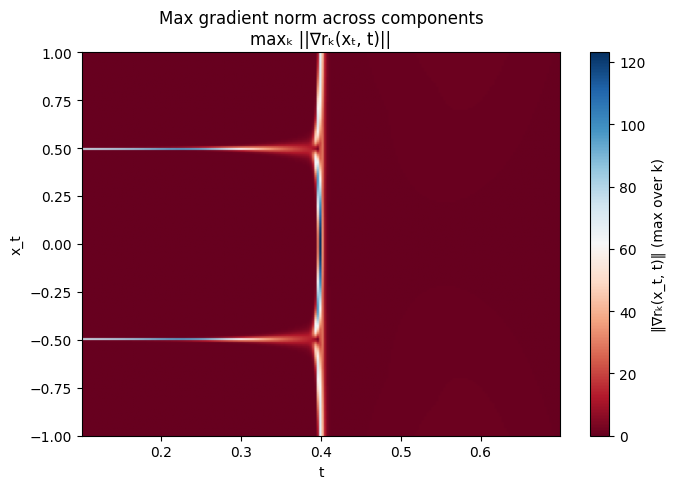

In [7]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

# Disable LaTeX rendering to avoid errors
mpl.rcParams['text.usetex'] = False

LAMBDA_MIN, LAMBDA_MAX = -10, 10 

#original_means = torch.tensor([ 0, -1.25, 0, 1.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([0, 1/4, 1/4, 1/4, 1/4], dtype=torch.float32)#1,0,0 #1,1,0

#original_means = torch.tensor([ -1.5, -0.25, 0, 0.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5], dtype=torch.float32)

                       
original_means = torch.tensor([-0.5, 0.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.002, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32) 

#original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0


original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.001, dtype=torch.float32) #0.4
weights = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float32)

def gradient_max_heatmap(t_vals, x_vals, means, variance, weights):
    """
    Compute and plot a heatmap where each pixel corresponds to
    max_k ||∇r_k(x_t, t)|| across all mixture components.
    """
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")

    T_flat = T.flatten().requires_grad_(True)
    X_flat = X.flatten().requires_grad_(True)

    r = responsibilities(X_flat, T_flat, means, variance, weights)  # (N*M, K)

    grad_norms = []
    for k in range(r.shape[1]):
        grad_t, grad_x = torch.autograd.grad(
            outputs=r[:, k],
            inputs=(T_flat, X_flat),
            grad_outputs=torch.ones_like(r[:, k]),
            create_graph=False,
            retain_graph=True
        )
        grad_norm = torch.sqrt(grad_t**2 + grad_x**2)
        grad_norms.append(grad_norm.unsqueeze(1))  # shape (N*M, 1)

    grad_norms = torch.cat(grad_norms, dim=1)  # (N*M, K)
    max_grad = grad_norms.max(dim=1).values  # (N*M,)

    max_grad_2d = max_grad.detach().numpy().reshape(len(t_vals), len(x_vals))

    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        max_grad_2d.T,
        extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()],
        origin="lower",
        aspect="auto",
         cmap='RdBu',
    )
    plt.title("Max gradient norm across components\nmaxₖ ||∇rₖ(xₜ, t)||")
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.colorbar(im, label="‖∇rₖ(x_t, t)‖ (max over k)")
    plt.tight_layout()
    plt.show()


# Example usage
t_vals = torch.linspace(0.1, 0.7, 200)
x_vals = torch.linspace(-1, 1, 200)

gradient_max_heatmap(t_vals, x_vals, original_means, original_variance, weights)

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        ...,
        [0.3298, 0.3333, 0.3369],
        [0.3298, 0.3333, 0.3369],
        [0.3297, 0.3333, 0.3369]], grad_fn=<ExpBackward0>)


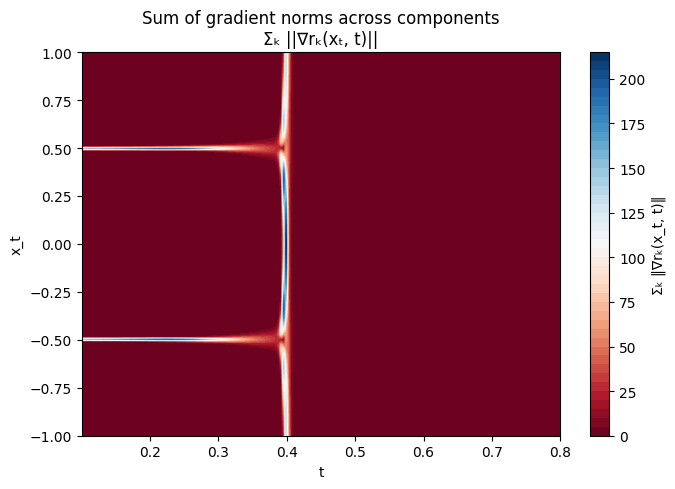

In [8]:
def gradient_sum_heatmap(t_vals, x_vals, means, variance, weights):
    """
    Compute and plot a heatmap or contour plot where each pixel corresponds to
    Σₖ ||∇rₖ(x_t, t)|| (sum over all mixture components).
    """
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")

    T_flat = T.flatten().requires_grad_(True)
    X_flat = X.flatten().requires_grad_(True)

    r = responsibilities(X_flat, T_flat, means, variance, weights)  

    grad_norms = []
    for k in range(r.shape[1]):
        grad_t, grad_x = torch.autograd.grad(
            outputs=r[:, k],
            inputs=(T_flat, X_flat),
            grad_outputs=torch.ones_like(r[:, k]),
            create_graph=False,
            retain_graph=True
        )
        grad_norm = torch.sqrt(grad_t**2 + grad_x**2)
        grad_norms.append(grad_norm.unsqueeze(1))  

    grad_norms = torch.cat(grad_norms, dim=1)  
    sum_grad = grad_norms.sum(dim=1) 
    sum_grad_2d = sum_grad.detach().numpy().reshape(len(t_vals), len(x_vals))

    # Contour plot (counterplot)
    plt.figure(figsize=(7, 5))
    cs = plt.contourf(
        t_vals.numpy(),
        x_vals.numpy(),
        sum_grad_2d.T,
        levels=50,
        cmap='RdBu'
    )
    plt.title("Sum of gradient norms across components\nΣₖ ||∇rₖ(xₜ, t)||")
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.colorbar(cs, label="Σₖ ‖∇rₖ(x_t, t)‖")
    plt.tight_layout()
    plt.show()


t_vals = torch.linspace(0.1, 0.8, 200)
x_vals = torch.linspace(-1, 1, 200)

gradient_sum_heatmap(t_vals, x_vals, original_means, original_variance, weights)


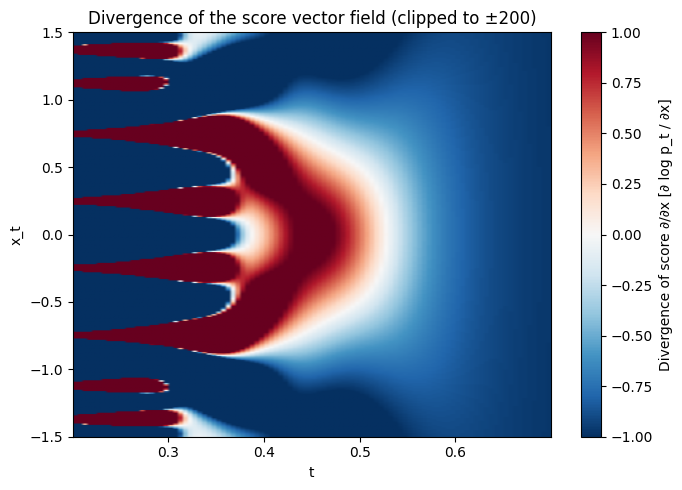

In [29]:
original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0

def divergence_of_score_heatmap():
    n_t, n_x = 100, 300
    t_vals = torch.linspace(0.2, 0.7, n_t)
    x_vals = torch.linspace(-1.5, 1.5, n_x)

    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")
    T_flat = T.flatten().requires_grad_(False)
    X_flat = X.flatten().requires_grad_(True)

    # Compute log p_t
    log_p = gaussian_mixture_density(X_flat, T_flat)

    # First derivative: score (grad log p wrt x)
    score = torch.autograd.grad(log_p.sum(), X_flat, create_graph=True)[0]

    # Second derivative: divergence (∂/∂x of score)
    divergence = torch.autograd.grad(score.sum(), X_flat, create_graph=False)[0]

    # Reshape to grid
    div_2d = divergence.detach().numpy().reshape(n_t, n_x)

    # Clip extreme values for better visualization
    div_2d = np.clip(div_2d, -1, 1)

    # Plot
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        div_2d.T,
        extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()],
        origin="lower", aspect="auto", cmap="RdBu_r"
    )
    plt.colorbar(im, label="Divergence of score ∂/∂x [∂ log p_t / ∂x]")
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.title("Divergence of the score vector field (clipped to ±200)")
    plt.tight_layout()
    plt.show()

# Run the visualization
divergence_of_score_heatmap()

tensor([[1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        ...,
        [0.4975, 0.5025],
        [0.4974, 0.5026],
        [0.4973, 0.5027]])


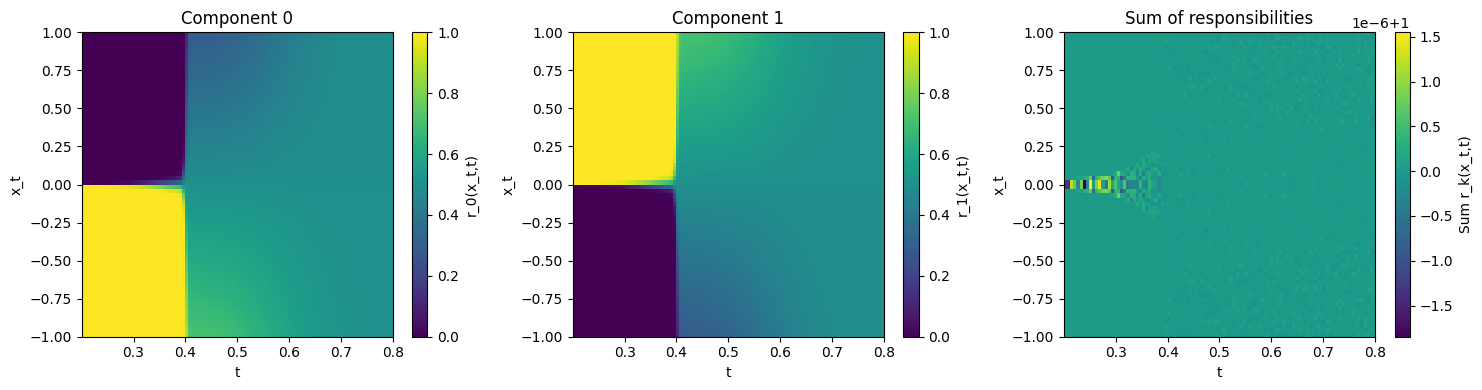

In [9]:
import torch
import matplotlib.pyplot as plt

import torch
import matplotlib.pyplot as plt


#original_means = torch.tensor([-2.5, -1.5, -0.25, 0.25, 1.5, 2.5], dtype=torch.float32)
#original_variance = torch.tensor(0.0002, dtype=torch.float32)
#weights = torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], dtype=torch.float32)  #1,0,0 #1,1,0

original_means = torch.tensor([-0.5, 0.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.002, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #1,0,0 #1,1,0

#original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0


#original_means = torch.tensor([ -1.5, -0.25, 0, 0.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5], dtype=torch.float32)

LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max log

def scatter_all_responsibilities_with_sum(t_vals, x_vals, means, variance, weights):
    """
    Heatmaps of responsibilities r_k(x_t,t) for all Gaussian mixture components,
    plus a combined heatmap of the sum of responsibilities.

    Now plots t on the x-axis and x_t on the y-axis.
    """
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")

    r = responsibilities(X.flatten(), T.flatten(),
                         means, variance, weights)  # shape (N*M, K)
    
    num_components = r.shape[1]

    fig, axes = plt.subplots(1, num_components + 1, figsize=(5*(num_components+1), 4))

    if num_components == 1:
        axes = [axes]  # ensure iterable

    for k in range(num_components):
        r_k = r[:, k].detach().numpy().reshape(len(t_vals), len(x_vals))
        im = axes[k].imshow(r_k.T,  # transpose to flip axes
                            extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()],
                            origin="lower", aspect="auto", cmap="viridis")
        axes[k].set_title(f"Component {k}")
        axes[k].set_xlabel("t")
        axes[k].set_ylabel("x_t")
        fig.colorbar(im, ax=axes[k], label=f"r_{k}(x_t,t)")

    # Sum of responsibilities
    r_sum = r.sum(dim=1).detach().numpy().reshape(len(t_vals), len(x_vals))
    im_sum = axes[num_components].imshow(r_sum.T,
                                         extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()],
                                         origin="lower", aspect="auto", cmap="viridis")
    axes[num_components].set_title("Sum of responsibilities")
    axes[num_components].set_xlabel("t")
    axes[num_components].set_ylabel("x_t")
    fig.colorbar(im_sum, ax=axes[num_components], label="Sum r_k(x_t,t)")

    plt.tight_layout()
    plt.show()


# Example usage
t_vals = torch.linspace(0.2, 0.8, 100)
x_vals = torch.linspace(-1, 1, 70)

scatter_all_responsibilities_with_sum(t_vals, x_vals, 
                                       original_means, original_variance, weights)



tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.2039e-45],
        [1.0000e+00, 3.3113e-42],
        [1.0000e+00, 4.4760e-39],
        [1.0000e+00, 7.8475e-36],
        [1.0000e+00, 1.5514e-32],
        [1.0000e+00, 2.9460e-29],
        [1.0000e+00, 4.6513e-26],
        [1.0000e+00, 5.2781e-23],
        [1.0000e+00, 3.8732e-20],
        [1.0000e+00, 1.6910e-17],
        [1.0000e+00, 4.1699e-15],
        [1.0000e+00, 5.6995e-13],
        [1.0000e+00, 4.3354e-11],
        [1.0000e+00, 1.8879e-09],
        [1.0000e+00, 6.2970e-08],
        [9.909

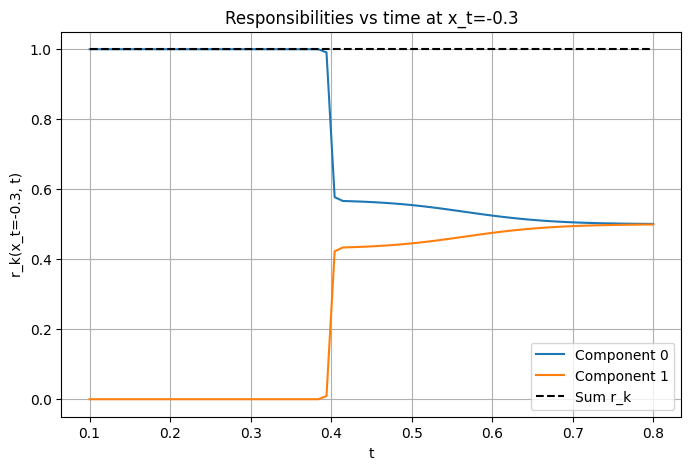

In [10]:
import torch
import matplotlib.pyplot as plt

def plot_responsibilities_vs_time(x_fixed, t_vals, means, variance, weights):
    """
    Plot responsibilities r_k(x_fixed, t) for all Gaussian mixture components as a function of t.
    
    Parameters
    ----------
    x_fixed : float
        The value of x_t to fix.
    t_vals : torch.Tensor
        1D tensor of time values.
    means : torch.Tensor
        Tensor of mixture means.
    variance : float
        Variance of each Gaussian component (same for all).
    weights : torch.Tensor
        Tensor of mixture weights.
    """
    # Repeat x_fixed for all t
    x_vals = x_fixed * torch.ones_like(t_vals)

    # Compute responsibilities
    r = responsibilities(x_vals, t_vals, means, variance, weights)  # shape (len(t_vals), K)
    num_components = r.shape[1]

    plt.figure(figsize=(8,5))
    
    for k in range(num_components):
        r_k = r[:, k].detach().numpy()
        plt.plot(t_vals.numpy(), r_k, label=f"Component {k}")
    
    # Optional: plot sum of responsibilities (should be 1 for a proper mixture)
    r_sum = r.sum(dim=1).detach().numpy()
    plt.plot(t_vals.numpy(), r_sum, "--", color="black", label="Sum r_k")
    
    plt.xlabel("t")
    plt.ylabel(f"r_k(x_t={x_fixed}, t)")
    plt.title(f"Responsibilities vs time at x_t={x_fixed}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage
x_fixed = -0.3  # choose a fixed x_t
t_vals = torch.linspace(0.1, 0.8, 70)

plot_responsibilities_vs_time(x_fixed, t_vals, original_means, original_variance, weights)


In [11]:

'''
Compute Sectional Curvature
'''


import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F
'''
def metric_tensor_differentiable(theta, lambda_reg=1e-6,n_steps=10, dt=0.1):
    """
    Compute a differentiable, positive-definite metric tensor
    whose components are smoothed by discrete heat equation
    evolution on the (t, x) grid.

    Parameters
    ----------
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x)
    eta, mu : callables
        Maps theta -> (eta_t, eta_x) and (mu_t, mu_x)
    lambda_reg : float
        Ridge term to enforce PD
    n_steps : int
        Number of diffusion steps
    dt : float
        Time step of the heat equation (controls smoothing strength)

    Returns
    -------
    I_smooth : torch.Tensor
        Shape (N, 2, 2), smoothed metric tensor at each input theta
    theta : torch.Tensor
        Same input, requires_grad=True
    """
    # --- Step 0: make theta differentiable ---
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]
    device, dtype = theta.device, theta.dtype

    # --- Step 1: compute raw metric tensor field ---
    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)
    eta_vec = torch.stack([eta_t, eta_x], dim=1)
    mu_vec  = torch.stack([mu_t,  mu_x],  dim=1)

    I_batch = torch.zeros((N, 2, 2), dtype=dtype, device=device)
    for n in range(N):
        J_eta = torch.zeros((2, 2), dtype=dtype, device=device)
        J_mu  = torch.zeros((2, 2), dtype=dtype, device=device)
        for k in range(2):
            grad_eta = torch.autograd.grad(eta_vec[n, k], theta, retain_graph=True, create_graph=True)[0][n]
            grad_mu  = torch.autograd.grad(mu_vec[n, k],  theta, retain_graph=True, create_graph=True)[0][n]
            J_eta[k, :] = grad_eta
            J_mu[k, :]  = grad_mu
        I_batch[n] = J_eta.T @ J_mu

    # --- Step 2: place tensor components on a regular (t, x) grid ---
    t_vals, x_vals = theta[:, 0], theta[:, 1]
    t_unique, x_unique = torch.unique(t_vals), torch.unique(x_vals)
    Nt, Nx = len(t_unique), len(x_unique)
    if Nt == 0 or Nx == 0:
        raise RuntimeError("Empty grid in t or x.")

    I_grid = torch.zeros((4, Nt, Nx), dtype=dtype, device=device)
    for n in range(N):
        ti = (t_unique == t_vals[n]).nonzero(as_tuple=True)[0]
        xi = (x_unique == x_vals[n]).nonzero(as_tuple=True)[0]
        if ti.numel() == 0 or xi.numel() == 0:
            continue
        ti, xi = ti.item(), xi.item()
        I_grid[0, ti, xi] = I_batch[n, 0, 0]
        I_grid[1, ti, xi] = I_batch[n, 0, 1]
        I_grid[2, ti, xi] = I_batch[n, 1, 0]
        I_grid[3, ti, xi] = I_batch[n, 1, 1]

    # --- Step 3: discrete heat equation smoothing ---
    # Laplacian kernel for 2D grid
    lap_kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=dtype, device=device)
    lap_kernel = lap_kernel.unsqueeze(0).unsqueeze(0)  # (1,1,3,3)

    I_smooth_grid = I_grid.clone()
    for _ in range(n_steps):
        lap = torch.zeros_like(I_smooth_grid)
        for c in range(4):
            inp = I_smooth_grid[c:c+1].unsqueeze(0)  # (1,1,H,W)
            lap[c] = F.conv2d(inp, lap_kernel, padding=1).squeeze(0)
        I_smooth_grid = I_smooth_grid + dt * lap

    # --- Step 4: map smoothed components back to original order ---
    I_smooth = torch.zeros_like(I_batch)
    for n in range(N):
        ti = (t_unique == t_vals[n]).nonzero(as_tuple=True)[0]
        xi = (x_unique == x_vals[n]).nonzero(as_tuple=True)[0]
        if ti.numel() == 0 or xi.numel() == 0:
            continue
        ti, xi = ti.item(), xi.item()
        I_smooth[n, 0, 0] = I_smooth_grid[0, ti, xi]
        I_smooth[n, 0, 1] = I_smooth_grid[1, ti, xi]
        I_smooth[n, 1, 0] = I_smooth_grid[2, ti, xi]
        I_smooth[n, 1, 1] = I_smooth_grid[3, ti, xi]

    # --- Step 5: small ridge to enforce positive definiteness ---
    I_smooth = I_smooth + lambda_reg * torch.eye(2, device=device, dtype=dtype)

    return I_smooth, theta
'''



def compute_sectional_curvature3(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    # Lower the indices by multiplying with the metric:
    #print('R1212', R_1212)
    #print('R1012', R_up_i1)
    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    #print('first metric:', g[:, 0, 0])
    #print(R_lowered_1212, torch.det(g)  )

    # Sectional curvature K = R_{1212} / det(g) for 2D manifold (use lowered component)
    
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K



original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5
print('metric:', metric_tensor_differentiable(torch.tensor([[0.3, -0.1]])))
print('sectional 3', compute_sectional_curvature3(torch.tensor([[0.4, -0.4]])))



metric: (tensor([[[172.6635, 118.3752],
         [118.3752, 259.9699]]], grad_fn=<CopySlices>), tensor([[ 0.3000, -0.1000]], requires_grad=True))
sectional 3 tensor([2.6590], grad_fn=<DivBackward0>)


sectional curvature at t=0.10, xt=-0.60: -0.5026
sectional curvature at t=0.10, xt=-0.54: -0.5001
sectional curvature at t=0.10, xt=-0.47: -0.5000
sectional curvature at t=0.10, xt=-0.41: -0.5006
sectional curvature at t=0.10, xt=-0.35: -0.5007
sectional curvature at t=0.10, xt=-0.28: -0.4920
sectional curvature at t=0.10, xt=-0.22: -0.4900
sectional curvature at t=0.10, xt=-0.16: -0.5521
sectional curvature at t=0.10, xt=-0.09: -0.5166
sectional curvature at t=0.10, xt=-0.03: -0.4227
sectional curvature at t=0.10, xt=0.03: -0.4227
sectional curvature at t=0.10, xt=0.09: -0.5166
sectional curvature at t=0.10, xt=0.16: -0.5521
sectional curvature at t=0.10, xt=0.22: -0.4900
sectional curvature at t=0.10, xt=0.28: -0.4920
sectional curvature at t=0.10, xt=0.35: -0.5007
sectional curvature at t=0.10, xt=0.41: -0.5006
sectional curvature at t=0.10, xt=0.47: -0.5000
sectional curvature at t=0.10, xt=0.54: -0.5001
sectional curvature at t=0.10, xt=0.60: -0.5026
sectional curvature at t=0.14,

100%|██████████| 1000/1000 [00:03<00:00, 261.28it/s]


Energy of a geodesic: nan
Energy of pf ode trajectory: 13.642064094543457 theta1 tensor([1., 0.])
theta2 tensor([0.1000, 0.0000])


100%|██████████| 1000/1000 [00:03<00:00, 253.52it/s]


Energy of a geodesic: 17.952512741088867
Energy of pf ode trajectory: 0.38941821455955505 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -0.5214])


100%|██████████| 1000/1000 [00:03<00:00, 260.48it/s]


Energy of a geodesic: nan
Energy of pf ode trajectory: 0.16666287183761597 theta1 tensor([0.5000, 1.0000])
theta2 tensor([0.1000, 0.5342])


100%|██████████| 1000/1000 [00:03<00:00, 264.78it/s]

Energy of a geodesic: 0.212216317653656


<Figure size 500x500 with 0 Axes>

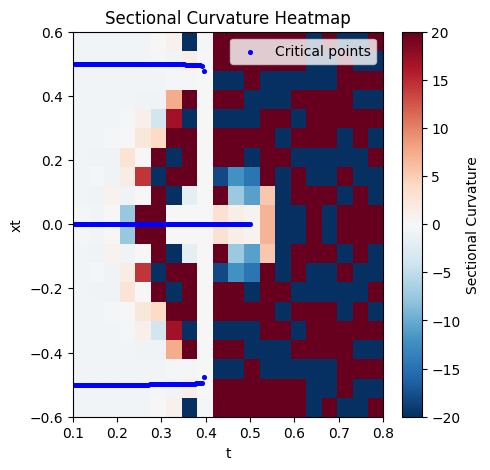

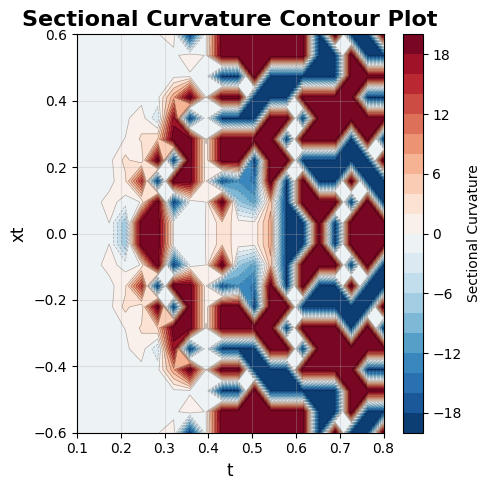


Heatmap computed with:
- t range: 0.1 to 0.8 (20 points)
- xt range: -0.6 to 0.6 (20 points)
- Curvature range: -20.0000 to 20.0000


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0

#original_means = torch.tensor([ -1.5, -0.25, 0, 0.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
#weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5],  dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values #-20,20#min/max logSNR values #-20,20

#original_means = torch.tensor([-2.5, -1.5, -0.25, 0.25, 1.5, 2.5], dtype=torch.float32)
#original_variance = torch.tensor(0.0002, dtype=torch.float32)
#weights = torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], dtype=torch.float32)  #1,0,0 #1,1,0
                       
original_means = torch.tensor([-0.5, 0.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #1,0,0 #1,1,0

#original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.001, dtype=torch.float32) #0.4
#weights = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float32)
                       
t_range = np.linspace(0.1, 0.8,20)  
xt_range = np.linspace(-0.6, 0.6, 20)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature3(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

plt.figure(figsize=(5, 5))
t_vals = np.linspace(t_min, 0.5, 100)
fixed_points = []

for t in t_vals:
    roots = find_fixed_points(t)
    for r in roots:
        fixed_points.append((t, r))

fixed_points = np.array(fixed_points)

plot_ode_geodesics(torch.tensor([[1.], [0.], [-1]]))


for i, x in enumerate(torch.tensor([[1.]])):
    pf_ode_sample = sample(x, 512, t_start=0.5, t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    print('theta1', theta1)
    print('theta2', theta2)
    #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
    #theta2 = torch.tensor([0.9999, 3.5])
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None


plt.figure(figsize=(5, 5))


plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')

plt.scatter(fixed_points[:, 0], fixed_points[:, 1], color='blue', s=7, label="Critical points")
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()


plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

C:\Users\maria\AppData\Local\Temp\ipykernel_29884\2505105347.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


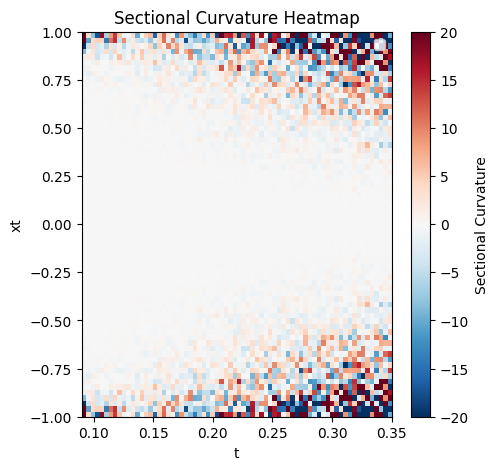

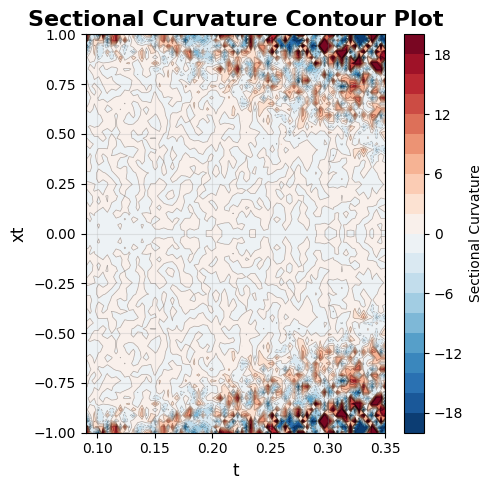


Heatmap computed with:
- t range: 0.1 to 0.3 (70 points)
- xt range: -1.0 to 1.0 (70 points)
- Curvature range: -20.0000 to 20.0000


In [28]:


plt.figure(figsize=(5, 5))


plt.imshow(curvature_values, extent=[t_range.min(), 0.35, xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')

plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()


plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

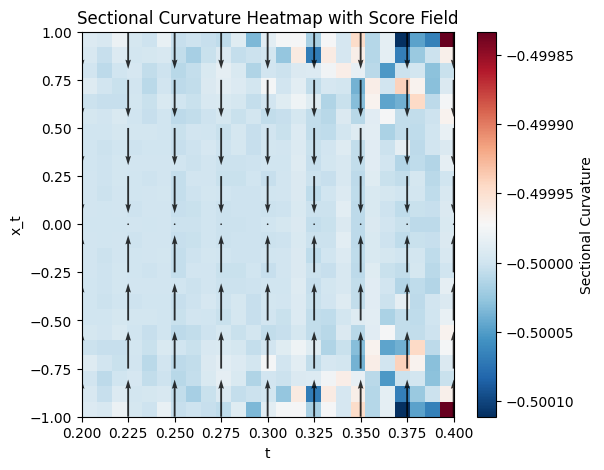

In [19]:
import matplotlib.pyplot as plt


LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values #-20,20#min/max logSNR values #-20,20

#original_means = torch.tensor([-2.5, -1.5, -0.25, 0.25, 1.5, 2.5], dtype=torch.float32)
#original_variance = torch.tensor(0.0002, dtype=torch.float32)
#weights = torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], dtype=torch.float32)  #1,0,0 #1,1,0
                       
original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #1,0,0 #1,1,0

# Create a meshgrid of t and x
t_range = np.linspace(0.2, 0.4, 25)  
xt_range = np.linspace(-1, 1, 25)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)
score_vectors = np.zeros_like(T)  # We'll store the x-component of the score

# Compute curvature and score at each grid point
for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        
        # Compute curvature
        curvature = compute_sectional_curvature3(tensor_input)
        curvature_values[j, i] = curvature.item() if torch.is_tensor(curvature) else curvature
        
        # Clamp extreme curvature values for visualization
        curvature_values[j, i] = np.clip(curvature_values[j, i], -20, 20)
        
        # Compute score field (gradient of log density)
        score_vectors[j, i] = score_function(xt, t)

import matplotlib.pyplot as plt
import numpy as np
import torch

# Assume curvature_values and score_vectors are already computed as in your code

plt.figure(figsize=(6, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(label='Sectional Curvature')

# Overlay vector field (small arrows)
skip = 3  # plot arrows every 2 points to reduce clutter
U = np.zeros_like(score_vectors[::skip, ::skip])  # horizontal component (along t)
V = score_vectors[::skip, ::skip]  # vertical component (along x_t)

# Optional: normalize vectors for better visualization
magnitude = np.sqrt(U**2 + V**2)
V_normalized = V / (magnitude + 1e-8)  # avoid division by zero

plt.quiver(T[::skip, ::skip], XT[::skip, ::skip], U, V_normalized,
           color='black', scale=10, width=0.005, alpha=0.8)

plt.title('Sectional Curvature Heatmap with Score Field')
plt.xlabel('t')
plt.ylabel('x_t')
plt.grid(False)
plt.show()


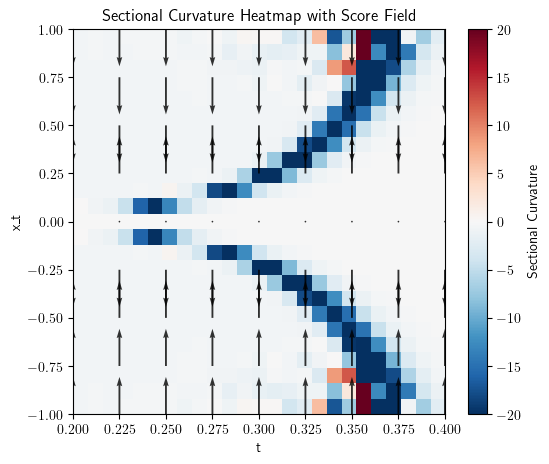

In [14]:
plt.figure(figsize=(6, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(label='Sectional Curvature')

# Overlay vector field (small arrows)
skip = 3  # plot arrows every 2 points to reduce clutter
U = np.zeros_like(score_vectors[::skip, ::skip])  # horizontal component (along t)
V = score_vectors[::skip, ::skip]  # vertical component (along x_t)

# Optional: normalize vectors for better visualization
magnitude = np.sqrt(U**2 + V**2)
V_normalized = V / (magnitude + 1e-8)  # avoid division by zero

plt.quiver(T[::skip, ::skip], XT[::skip, ::skip], U, V_normalized,
           color='black', scale=10, width=0.005, alpha=0.8)

plt.title('Sectional Curvature Heatmap with Score Field')
plt.xlabel('t')
plt.ylabel('x_t')
plt.grid(False)
plt.show()

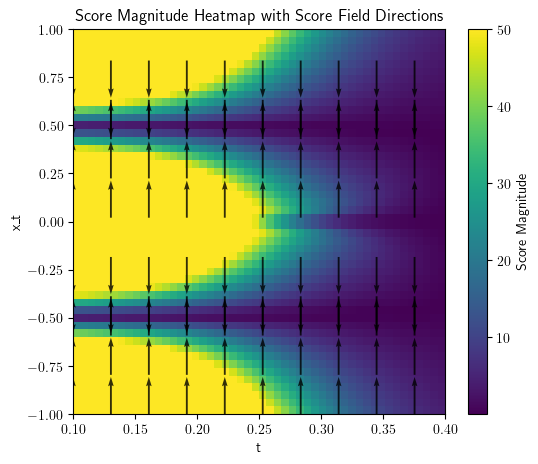

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Parameters
t_range = np.linspace(0.1, 0.4, 50)
xt_range = np.linspace(-1, 1, 50)
T, XT = np.meshgrid(t_range, xt_range)

# Arrays to store magnitude and vector components
score_magnitude = np.zeros_like(T)
U = np.zeros_like(T)  # horizontal component (t direction)
V = np.zeros_like(T)  # vertical component (x_t direction)

# Compute score and magnitude at each grid point
for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        # Compute score (gradient of log p_t(x) w.r.t x)
        s = score_function(xt, t)
        V[j, i] = s   # vertical component along x_t
        U[j, i] = 0   # horizontal component along t
        score_magnitude[j, i] = np.sqrt(U[j, i]**2 + V[j, i]**2)

        if score_magnitude[j, i] > 50:
            score_magnitude[j, i] = 50  # cap for visualization

# Plot heatmap of score magnitude
plt.figure(figsize=(6, 5))
plt.imshow(score_magnitude, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Score Magnitude')

# Overlay arrows to indicate direction
skip = 5  # plot every 3rd point to reduce clutter
U_norm = U[::skip, ::skip]
V_norm = V[::skip, ::skip]
magnitude_norm = np.sqrt(U_norm**2 + V_norm**2)
V_norm = V_norm / (magnitude_norm + 1e-8)  # normalize for visualization

plt.quiver(T[::skip, ::skip], XT[::skip, ::skip], U_norm, V_norm,
           color='black', scale=10, width=0.005, alpha=0.8)

plt.title('Score Magnitude Heatmap with Score Field Directions')
plt.xlabel('t')
plt.ylabel('x_t')
plt.grid(False)
plt.show()


Energy of pf ode trajectory: 0.026904035359621048 theta1 [0.5 0.5]
theta2 [0.10000324 2.413348  ]


100%|██████████| 2000/2000 [00:32<00:00, 60.66it/s]


[ 0.01 -2.  ] [0.01     1.999999]


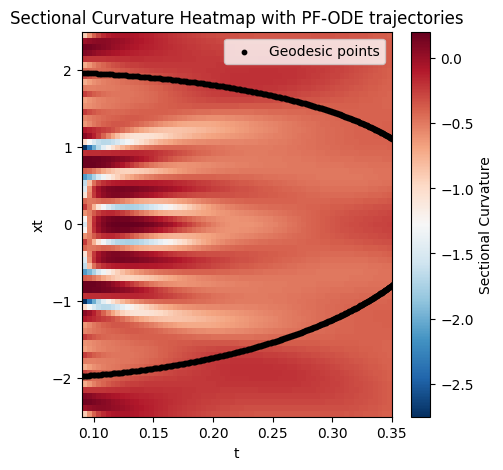

Geodesic t-range: -2.003003 1.999999
Geodesic xt-range: 0.01 0.39249432
Plot t_range: 0.09 0.35
Plot xt_range: -2.5 2.5


In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))


# Background curvature heatmap
im = ax.imshow(
    curvature_values,
    extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
    origin='lower',
    aspect='auto',
    cmap='RdBu_r'
)
fig.colorbar(im, ax=ax, label='Sectional Curvature')

# Critical points
#ax.scatter(fixed_points[:, 0], fixed_points[:, 1],
           #color='blue', s=7, label="Critical points", zorder=6)

# Overlay PF-ODE trajectories
for i, x in enumerate(torch.tensor([[.5]])):
    pf_ode_sample = sample(x, 512, t_start=0.5, t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    pf_ode_np = pf_ode_theta.cpu().numpy()

    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    print('theta1', pf_ode_np[0])
    print('theta2', pf_ode_np[-1])

    if i == 0:
        label_pf = 'PF-ODE trajectory'
    else:
        label_pf = None

    #ax.plot(pf_ode_np[:, 0], pf_ode_np[:, 1],
            #color='green', lw=1.8, label=label_pf, zorder=7)

# geodesic via energy minimization (also swap axes)
shortest_path12 = geodesic(torch.tensor([0.01, -2]),   torch.tensor([0.01, 2]),
                           n_opt_steps=2000, num_intermediate_points=1000, num_nodes=2)
ax.scatter(shortest_path12[:, 0], shortest_path12[:, 1],
           color='black', s=10, label='Geodesic points', zorder=8)


print(shortest_path12[0], shortest_path12[-1])
# Final touches
ax.set_title('Sectional Curvature Heatmap with PF-ODE trajectories')
ax.set_xlabel('t')
ax.set_ylabel('xt')
ax.set_xlim(t_range.min(), t_range.max())
ax.set_ylim(xt_range.min(), xt_range.max())
ax.legend()
plt.show()


print("Geodesic t-range:", shortest_path12[:, 1].min(), shortest_path12[:, 1].max())
print("Geodesic xt-range:", shortest_path12[:, 0].min(), shortest_path12[:, 0].max())
print("Plot t_range:", t_range.min(), t_range.max())
print("Plot xt_range:", xt_range.min(), xt_range.max())



## Other

In [ ]:
def compute_sectional_curvature(theta):
    """
    Compute sectional curvature using Christoffel symbols.
    For 2D manifolds, sectional curvature equals Gaussian curvature.

    Parameters:
    -----------
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)

    Returns:
    --------
    K : torch.Tensor
        Shape (N,), sectional curvature at each point
    """
    # Get metric tensor and differentiable coordinates
    g, theta_diff = metric_tensor_differentiable(theta)  # g: (N, 2, 2)
    N = g.shape[0]

    # Compute inverse metric
    g_inv = torch.inverse(g)  # (N, 2, 2)

    # Compute Christoffel symbols Γ^k_ij
    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    # First, compute all partial derivatives of metric components: ∂_k g_ij
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        for i in range(2):
            for j in range(2):
                grad_outputs = torch.ones_like(g[n, i, j])
                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  # Shape (2,)
                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij = (1/2) * g^kl * (∂_j g_il + ∂_i g_jl - ∂_l g_ij)
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (
                            g_derivs[n, i, l, j] +    # ∂_j g_il
                            g_derivs[n, j, l, i] -    # ∂_i g_jl
                            g_derivs[n, i, j, l]      # ∂_l g_ij
                        )
                        sum_term += g_inv[n, k, l] * bracket_term
                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R_{1212}
    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    # Fixed indexing: i=0, j=1, k=0, l=1 for R_{1212}
    i, j, k, l = 0, 1, 0, 1

    for n in range(N):
        # ∂_k Γ^i_jl
        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=True,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        # ∂_l Γ^i_jk
        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=True,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        # Quadratic terms: Γ^i_mk * Γ^m_jl - Γ^i_ml * Γ^m_jk
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        # R^i_{jkl} = derivative terms + quadratic terms
        R_upper = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

        # Lower first index: R_{ijkl} = g_{im} R^m_{jkl}
        R_ijkl = sum(g[n, i, m] * R_upper for m in range(2))

        R_1212[n] = R_ijkl

    # Sectional curvature K = R_{1212} / det(g) for 2D manifold
    det_g = torch.det(g)  # (N,)
    K = R_1212 / det_g

    return K

import torch
import torch

def gaussian_curvature_shortcut(theta, eps=1e-12):
    """
    Correct implementation of the 'shortcut' formula for Gaussian curvature in 2D.
    Inputs:
        theta: (N,2) torch.Tensor (coordinates). metric_tensor_differentiable(theta) must return (g, theta_diff).
    Returns:
        K: (N,) Gaussian curvature
    """
    # get metric and the differentiable coordinates used inside metric_tensor_differentiable
    g, theta_diff = metric_tensor_differentiable(theta)  # g: (N,2,2), theta_diff: (N,2) or similar
    # ensure theta_diff requires grad (if it isn't already)
    theta_diff.requires_grad_(True)

    g00 = g[:, 0, 0]  # (N,)
    g01 = g[:, 0, 1]  # (N,)
    g11 = g[:, 1, 1]  # (N,)

    # helper: compute vector-Jacobian of a vector (N,) wrt theta_diff -> returns (N,2)
    def deriv_vec(vec):
        # vec: (N,)
        grads = torch.autograd.grad(
            vec,
            theta_diff,
            grad_outputs=torch.ones_like(vec),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]  # shape (N,2)
        return grads

    # compute first derivatives of metric components: each is (N,2) (du, dv)
    dg00 = deriv_vec(g00)  # dg00[:,0] = ∂_u g00, dg00[:,1] = ∂_v g00
    dg01 = deriv_vec(g01)
    dg11 = deriv_vec(g11)

    dg00_du = dg00[:, 0]; dg00_dv = dg00[:, 1]
    dg01_du = dg01[:, 0]; dg01_dv = dg01[:, 1]
    dg11_du = dg11[:, 0]; dg11_dv = dg11[:, 1]

    # determinant and sqrt (numerical safe)
    det_g = g00 * g11 - g01 * g01
    sqrt_det_g = torch.sqrt(det_g.clamp(min=eps))

    # CORRECT inner bracket terms (note the order)
    inner1 = (dg00_dv - dg01_du) / sqrt_det_g   # (∂_v g_00 - ∂_u g_01)/sqrt(det)
    inner2 = (dg11_du - dg01_dv) / sqrt_det_g   # (∂_u g_11 - ∂_v g_01)/sqrt(det)

    # derivatives of the inner terms
    dinner1 = deriv_vec(inner1)  # shape (N,2)
    d_inner1_du = dinner1[:, 0]

    dinner2 = deriv_vec(inner2)
    d_inner2_dv = dinner2[:, 1]

    # final formula
    K = -(d_inner1_du + d_inner2_dv) / (2.0 * sqrt_det_g)

    return K


def compute_sectional_curvature2(theta):
    """
    Compute sectional curvature using Christoffel symbols.
    For 2D manifolds, sectional curvature equals Gaussian curvature.
    
    Parameters:
    -----------
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    
    Returns:
    --------
    K : torch.Tensor
        Shape (N,), sectional curvature at each point
    """
    # Get metric tensor and differentiable coordinates
    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    
    # Compute inverse metric
    g_inv = torch.inverse(g)  # (N, 2, 2)
    
    # Compute Christoffel symbols Γ^k_ij
    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    
    # First, compute all partial derivatives of metric components
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    
    for n in range(N):
        for i in range(2):
            for j in range(2):
                # ∂g_ij/∂θ^k
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0
                
                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  # Shape (2,)
                
                g_derivs[n, i, j, :] = grad_g_ij
    
    # Compute Christoffel symbols: Γ^k_ij = (1/2) * g^kl * (∂g_il/∂θ^j + ∂g_jl/∂θ^i - ∂g_ij/∂θ^l)
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    # ∂g_il/∂θ^j
                                       g_derivs[n, j, l, i] -     # ∂g_jl/∂θ^i
                                       g_derivs[n, i, j, l])      # ∂g_ij/∂θ^l
                        sum_term += g_inv[n, k, l] * bracket_term
                    
                    christoffel[n, k, i, j] = 0.5 * sum_term
    
    # Compute Riemann tensor component R^1_212
    # R^i_jkl = ∂Γ^i_jl/∂θ^k - ∂Γ^i_jk/∂θ^l + Γ^i_mk*Γ^m_jl - Γ^i_ml*Γ^m_jk
    
    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)
    
    for n in range(N):
        # For R^1_212: i=1, j=2, k=1, l=2
        #i, j, k, l = 1, 2, 1, 2  # Using 0-indexing: i=1->0, j=2->1, etc.
        i, j, k, l = 0, 1, 0, 1  # Convert to 0-indexing
        
        # Compute ∂Γ^1_22/∂θ^1 (∂Γ^0_11/∂θ^0 in 0-indexing)
        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)
        
        # Compute ∂Γ^1_21/∂θ^2 (∂Γ^0_10/∂θ^1 in 0-indexing)  
        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)
        
        # Quadratic terms: Γ^1_m1*Γ^m_22 - Γ^1_m2*Γ^m_21
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))
        
        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2
    

    
    # Sectional curvature K = R^1_212 / det(g) for 2D manifold
    det_g = torch.det(g)  # (N,)
    K = R_1212 / det_g
    
    return K


In [12]:
def create_curvature_heatmap(t_min, t_max, x_min=-1, x_max=1, n_t=30, n_x=30):
    """
    Create a heatmap of sectional curvature values.
    
    Parameters:
    -----------
    t_min, t_max : float
        Time range
    x_min, x_max : float  
        Spatial range
    n_t, n_x : int
        Grid resolution
    """
    
    # Create coordinate grid
    t_vals = torch.linspace(t_min, t_max, n_t)
    x_vals = torch.linspace(x_min, x_max, n_x)
    
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")  # Shape: (n_t, n_x)
    K_vals = torch.zeros_like(T)
    
    # Compute sectional curvature on grid
    print("Computing sectional curvature on grid...")
    for i in range(n_t):
        if i % 10 == 0:  # Progress indicator
            print(f"Processing time step {i}/{n_t}")
        for j in range(n_x):
            # theta = (t, x_t), where T[i,j] is time and X[i,j] is spatial coordinate
            # With indexing="ij": T varies along rows (i), X varies along cols (j)
            theta = torch.tensor([[T[i, j].item(), X[i, j].item()]], 
                               dtype=torch.float32, requires_grad=True)
            try:
                K_val = compute_sectional_curvature(theta)
                K_vals[i, j] = K_val[0]  # Extract scalar value
            except Exception as e:
                print(f"Error at ({T[i,j]:.2f}, {X[i,j]:.2f}): {e}")
                K_vals[i, j] = float("nan")  # skip invalid points
    
    print("Curvature values computed.")
    K_vals_np = K_vals.detach().numpy()
    print(f"Curvature range: [{np.nanmin(K_vals_np):.3f}, {np.nanmax(K_vals_np):.3f}]")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Heatmap
    im = ax.imshow(
        K_vals_np, origin="lower", 
        extent=(t_min, t_max, x_min, x_max),
        aspect="auto", cmap="RdBu_r", 
        vmin=np.nanpercentile(K_vals_np, 5),
        vmax=np.nanpercentile(K_vals_np, 95)
    )
    fig.colorbar(im, ax=ax, label="Sectional Curvature K", shrink=0.8)
    
    # Overlay trajectories if you have the functions available
    # Uncomment and modify as needed:
    """
    for i, x in enumerate(torch.tensor([[-0.5], [0.], [0.5]])):
        try:
            # Replace with your actual trajectory generation functions
            pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
            pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
            theta1 = pf_ode_theta[0]
            theta2 = pf_ode_theta[-1]
            shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, 
                                     num_intermediate_points=128, num_nodes=2)
            
            if i == 0:
                label_pf = 'PF-ODE trajectory'
                label_g = 'Spacetime Geodesic'
            else:
                label_pf = None
                label_g = None
                
            ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], 
                   color='white', linewidth=2, label=label_pf)
            ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], 
                   color='yellow', linestyle='--', linewidth=2, label=label_g)
        except:
            print(f"Could not plot trajectory {i}")
    
    ax.legend(loc='upper right')
    """
    
    ax.set_xlim((t_min, t_max))
    ax.set_ylim((x_min, x_max))
    ax.set_xlabel(r'$t$', fontsize=14)
    ax.set_ylabel(r'$x$', fontsize=14)
    ax.set_title('Sectional Curvature Heatmap', fontsize=16)
    
    # Add contour lines for better visualization
    contour_levels = np.linspace(np.nanpercentile(K_vals_np, 10), 
                                np.nanpercentile(K_vals_np, 90), 8)
    ax.contour(T.numpy(), X.numpy(), K_vals_np, levels=contour_levels, 
               colors='black', alpha=0.3, linewidths=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return K_vals_np, T.numpy(), X.numpy()
create_curvature_heatmap(0.1,0.9)

Computing sectional curvature on grid...
Processing time step 0/30


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def create_curvature_heatmap(compute_sectional_curvature, t_min, t_max, x_min=-1, x_max=1, n_t=50, n_x=50):
    """
    Creates a heatmap of sectional curvature values over a grid of (t, x_t).

    Parameters:
    -----------
    compute_sectional_curvature : function
        Function that takes a tensor of shape (N, 2) and returns sectional curvature.
    t_min, t_max : float
        Time range.
    x_min, x_max : float
        Spatial range.
    n_t, n_x : int
        Number of grid points in time and space directions.
    """
    
    # Create grid
    t_vals = torch.linspace(t_min, t_max, n_t)
    x_vals = torch.linspace(x_min, x_max, n_x)
    T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")  # (n_t, n_x)

    points = torch.stack([T.flatten(), X.flatten()], dim=1)  # Shape: (n_t * n_x, 2)
    points.requires_grad_(True)

    # Compute curvature for all points at once
    K = compute_sectional_curvature(points)  # Shape: (n_t * n_x,)
    K_vals = K.reshape(n_t, n_x).detach().cpu().numpy()

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        K_vals, origin="lower",
        extent=(x_min, x_max, t_min, t_max),
        aspect="auto", cmap="RdBu_r",
        vmin=np.percentile(K_vals, 5),
        vmax=np.percentile(K_vals, 95)
    )
    fig.colorbar(im, ax=ax, label="Sectional Curvature K")

    ax.set_xlabel(r"$x_t$", fontsize=14)
    ax.set_ylabel(r"$t$", fontsize=14)
    ax.set_title("Sectional Curvature Heatmap", fontsize=16)
    
    plt.show()

    return K_vals, T.detach().cpu().numpy(), X.detach().cpu().numpy()


create_curvature_heatmap(compute_sectional_curvature, 0.1,0.9)


In [ ]:
# Test with a known point
theta_test = torch.tensor([[0.5, -1.0]], requires_grad=True)  # t=0.5, x_t=0.0
K_test = compute_sectional_curvature(theta_test)
print(f"Curvature at (t=0.5, x_t=0.0): {K_test[0]:.3f}")

Curvature at (t=0.5, x_t=0.0): -8.999


In [ ]:
# Example theta: shape (N, 2) = (t, x_t)
theta_input = torch.tensor([[0.5, -1.0]], dtype=torch.float32, requires_grad=True)

# Compute metric tensor
I_batch, theta = metric_tensor_differentiable(theta_input)

N = theta.shape[0]

# Store derivatives of each component w.r.t t
dI_dt = torch.zeros((N, 2, 2), dtype=theta.dtype)

for i in range(2):
    for j in range(2):
        I_ij = I_batch[:, i, j]  # shape (N,)
        grad_Iij = torch.autograd.grad(
            I_ij.sum(), theta, create_graph=True
        )[0]  # shape (N, 2)
        dI_dt[:, i, j] = grad_Iij[:, 0]  # derivative w.r.t t (theta[:,0])

print("Metric tensor:\n", I_batch)
print("\nDerivatives w.r.t t:\n", dI_dt)


Metric tensor:
 tensor([[[0.5093, 0.3889],
         [0.3889, 0.3333]]], grad_fn=<CopySlices>)

Derivatives w.r.t t:
 tensor([[[-1.3519, -1.0185],
         [-1.0185, -0.8889]]], grad_fn=<CopySlices>)


In [ ]:
import torch

def mu(theta):
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)

    # no .requires_grad_ here, x already depends on theta
    f = eds(t, x)

    # take gradient wrt theta, then select x-component
    grads = torch.autograd.grad(f.sum(), theta, create_graph=True)[0]  # shape (N,2)
    div = grads[:, 1]  # derivative wrt x (second coordinate)

    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x


def metric_tensor(theta):
    """
    Compute I(theta) = (d eta / d theta)^T (d mu / d theta) for a batch of points.
    theta: (N,2) tensor
    Returns: (N,2,2) metric tensors
    """
    theta = theta.clone().requires_grad_(True)   # leaf with grad
    N = theta.shape[0]
    I = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        th = theta[n]  # shape (2,)

        # functions that accept a 1D (2,) tensor and return a 1D (2,) tensor
        def eta_single(inp):
            # eta expects a batch; pass (1,2) and return (2,)
            e_t, e_x = eta(inp.unsqueeze(0))
            return torch.stack([e_t.squeeze(0), e_x.squeeze(0)])

        def mu_single(inp):
            m_t, m_x = mu(inp.unsqueeze(0))
            return torch.stack([m_t.squeeze(0), m_x.squeeze(0)])

        # jacobians: shape (out_dim, in_dim) = (2,2)
        J_eta = torch.autograd.functional.jacobian(eta_single, th, create_graph=True)
        J_mu = torch.autograd.functional.jacobian(mu_single, th, create_graph=True)

        # metric
        I[n] = J_eta.T @ J_mu

    return I


def gaussian_curvature2(theta, eps=1e-12):
    """
    Compute Gaussian curvature K(theta) for a batch of points (2D).
    theta: (N,2) tensor
    Returns: (N,) tensor of curvatures
    """
    theta = theta.clone().requires_grad_(True)
    I = metric_tensor(theta)  # (N,2,2)
    N = theta.shape[0]
    Ks = []

    def grad_wrt_th(scalar, th):
        """
        returns gradient vector d scalar / d th  (shape (2,))
        safe: returns zeros if scalar doesn't depend on th
        """
        g = torch.autograd.grad(scalar, th, create_graph=True, retain_graph=True, allow_unused=True)[0]
        if g is None:
            return torch.zeros_like(th)
        return g

    for n in range(N):
        th = theta[n]            # (2,)
        gmat = I[n]              # (2,2)
        E = gmat[0, 0]
        F = gmat[0, 1]
        G = gmat[1, 1]

        det_g = E * G - F * F
        # numeric safety
        det_g = det_g.clamp(min=eps)
        sqrt_det = torch.sqrt(det_g)

        # first derivatives of metric components wrt (t,x)
        E_grad = grad_wrt_th(E, th)   # (2,)
        F_grad = grad_wrt_th(F, th)
        G_grad = grad_wrt_th(G, th)

        E_t, E_x = E_grad[0], E_grad[1]
        F_t, F_x = F_grad[0], F_grad[1]
        G_t, G_x = G_grad[0], G_grad[1]

        # Brioschi intermediate quantities (u=t, v=x)
        A = (G_t - 2.0 * F_x + E_x) / (sqrt_det + 1e-30)
        B = (E_x - 2.0 * F_t + G_t) / (sqrt_det + 1e-30)

        # second derivatives A_t and B_x
        A_grad = grad_wrt_th(A, th)
        B_grad = grad_wrt_th(B, th)
        A_t = A_grad[0]
        B_x = B_grad[1]

        K = -(A_t + B_x) / (2.0 * sqrt_det)
        Ks.append(K)

    return torch.stack(Ks)

print(gaussian_curvature2(torch.tensor([[0.3, 1]])))


tensor([-0.], grad_fn=<StackBackward0>)


In [ ]:
theta = torch.tensor([[0.3, 0.3]])
metric_tensor(theta)  # shape (1, 2)
#curvature_S(theta)

tensor([[[ 5.0000e+03,  2.0480e+03],
         [-7.5000e+01,  4.8516e+08]]], grad_fn=<CopySlices>)

In [ ]:

original_means = torch.tensor([0, 1, .1], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1, 0, 0], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -1, 1 #min/max logSNR values #-20,20

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def psi(theta):
    """
    Compute ψ(x_t, t) = log p_t(x_t) + D/2 log(2πσ_t^2) + ||x_t||^2 / (2σ_t^2)

    Parameters
    ----------
    theta: torch.Tensor
        Shape (2,), where theta[0] = x_t, theta[1] = t

    Returns
    -------
    psi_val: torch.Tensor
        scalar
    """
    x_t, t = theta[0], theta[1]
    D = 1  # dimensionality of x_t

    # alpha_sigma returns tensors, so ensure scalar extraction
    alpha_t, sigma_t = alpha_sigma(t.unsqueeze(0))
    alpha_t = alpha_t[0]
    sigma_t = sigma_t[0]

    log_p_t = gaussian_mixture_density(x_t.unsqueeze(0), t.unsqueeze(0))[0]

    term1 = log_p_t
    term2 = (D / 2) * torch.log(2 * torch.pi * sigma_t**2)
    term3 = x_t**2 / (2 * sigma_t**2)

    return term1 + term2 + term3

def metric_tensor_psi(theta):
    """
    Compute gij(θ) = second derivatives of ψ.

    Parameters
    ----------
    theta: torch.Tensor
        Shape (2,), where theta = [x_t, t]

    Returns
    -------
    g: torch.Tensor
        Shape (2, 2), the metric tensor
    """
    theta = theta.clone().detach().requires_grad_(True)
    g = torch.zeros((2, 2), dtype=torch.float32, device=theta.device)

    psi_val = psi(theta)
    grad_psi = torch.autograd.grad(psi_val, theta, create_graph=True)[0]

    for i in range(2):
        grad2_psi = torch.autograd.grad(grad_psi[i], theta, create_graph=True)[0]
        g[i, :] = grad2_psi

    return g


theta = torch.tensor([-0.1, 0.5], dtype=torch.float32)  # example (x_t, t)
g = metric_tensor_psi(theta)
print(g)

tensor([[ 0.3333,  0.0889],
        [ 0.0889, -0.2652]], grad_fn=<CopySlices>)


In [ ]:
_eps = 1e-12

def metric_from_psi_at_point(th):
    """
    Compute g (2x2) = Hessian(psi) at a single point th (shape (2,), requires_grad=True).
    Returns: g (2x2 tensor)
    """
    # psi should accept a 1D tensor theta of shape (2,)
    psi_val = psi(th)                      # scalar
    grad_psi = torch.autograd.grad(psi_val, th, create_graph=True)[0]  # shape (2,)

    g = torch.zeros((2, 2), device=th.device, dtype=th.dtype)
    # second derivatives: row i contains derivatives of grad_psi[i] w.r.t th
    for i in range(2):
        grad2 = torch.autograd.grad(grad_psi[i], th, create_graph=True)[0]  # shape (2,)
        g[i, :] = grad2
    # g[i,j] is ∂^2 psi / ∂θ_j ∂θ_i  — if you prefer symmetric ordering, we'll symmetrize:
    # ensure symmetry by averaging (to counter tiny numerical asymmetry)
    g = 0.5 * (g + g.T)
    return g

def curvature_S(theta):
    """
    Compute curvature S(theta) for either:
      - theta shape (2,)  single point
      - theta shape (N,2) batch of points

    Returns:
      tensor of shape (N,) for batch or scalar tensor for single point.
    """
    single = False
    if theta.ndim == 1:
        theta = theta.unsqueeze(0)  # (1,2)
        single = True
    N = theta.shape[0]
    device = theta.device
    dtype = theta.dtype

    S = torch.zeros(N, device=device, dtype=dtype)

    for i in range(N):
        # work pointwise to avoid cross-batch autodiff issues
        th = theta[i].clone().detach().requires_grad_(True)  # shape (2,)

        # compute metric g = Hessian(psi) at this point
        g = metric_from_psi_at_point(th)  # (2,2)

        # entries: g11 = g[0,0], g12 = g[0,1] (==g21), g22 = g[1,1]
        g11 = g[0, 0]
        g12 = g[0, 1]
        g22 = g[1, 1]

        # compute derivatives of each g_ij wrt theta = (x_t, t)
        # we need ∂1 g_ij and ∂2 g_ij. We'll compute grad(g_ij) which is shape (2,).
        dg11 = torch.autograd.grad(g11, th, retain_graph=True, create_graph=True)[0]  # [∂1 g11, ∂2 g11]
        dg12 = torch.autograd.grad(g12, th, retain_graph=True, create_graph=True)[0]  # [∂1 g12, ∂2 g12]
        dg22 = torch.autograd.grad(g22, th, retain_graph=True, create_graph=True)[0]  # [∂1 g22, ∂2 g22]

        # according to your formula, the 3x3 matrix rows are:
        # row1 = [ g11, ∂2 g11, ∂1 g11 ]
        # row2 = [ g12, ∂2 g12, ∂1 g12 ]
        # row3 = [ g22, ∂2 g22, ∂1 g22 ]
        # note: dgXX[0] = ∂1, dgXX[1] = ∂2
        mat3 = torch.zeros((3, 3), device=device, dtype=dtype)
        mat3[0, 0] = g11
        mat3[0, 1] = dg11[1]   # ∂2 g11
        mat3[0, 2] = dg11[0]   # ∂1 g11

        mat3[1, 0] = g12
        mat3[1, 1] = dg12[1]   # ∂2 g12
        mat3[1, 2] = dg12[0]   # ∂1 g12

        mat3[2, 0] = g22
        mat3[2, 1] = dg22[1]   # ∂2 g22
        mat3[2, 2] = dg22[0]   # ∂1 g22

        # numerator: determinant of the 3x3 matrix
        numerator = torch.det(mat3)

        # denominator: 4 * (det(g))^2 ; use small eps to avoid division by zero
        det_g = torch.det(g)
        denom = 4.0 * (det_g ** 2) + _eps

        S[i] = numerator / denom

    return S[0] if single else S

original_means = torch.tensor([0, 1, .1], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1, 0, 0], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -1, 1 #min/max logSNR values #-20,20

curvature_S(theta = torch.tensor([0.2, 0.6], dtype=torch.float32))  # example (x_t, t))

tensor(-2.4553, grad_fn=<SelectBackward0>)

[[ 2.44689319e-14  5.12357965e-14 -4.36795307e-14 -3.97925702e-15
   3.01032054e-14 -9.39517561e-14  2.19441063e-14 -4.28937400e-15
  -3.94681927e-13  4.17570329e-13  1.11838754e-13  3.85047083e-13
   4.31091496e-13  4.85445885e-12 -1.08247838e-11 -1.08247838e-11
   4.85445885e-12  4.31091496e-13  3.85047083e-13  1.11838754e-13
   4.17570329e-13 -3.94681927e-13 -4.28937400e-15  2.19441063e-14
  -9.39517561e-14  3.01032054e-14 -3.97925702e-15 -4.36795307e-14
   5.12357965e-14  2.44689319e-14]
 [-2.57619772e-13 -2.47720410e-13 -3.10304056e-13 -1.10292404e-13
  -3.04985583e-13 -4.25774840e-13 -4.16838141e-13 -1.02401063e-12
  -4.60144130e-13 -1.54067460e-12 -4.76752264e-13 -2.04793561e-12
  -7.35141462e-12 -2.10123655e-11 -1.31900935e-10 -1.31900935e-10
  -2.10123655e-11 -7.35141462e-12 -2.04793561e-12 -4.76752264e-13
  -1.54067481e-12 -4.60144130e-13 -1.02401074e-12 -4.16838141e-13
  -4.59570424e-13 -3.32650465e-13 -1.33355227e-13 -3.29824330e-13
  -2.64455911e-13 -2.72126505e-13]
 [-3.7

100%|██████████| 1000/1000 [00:10<00:00, 97.29it/s]


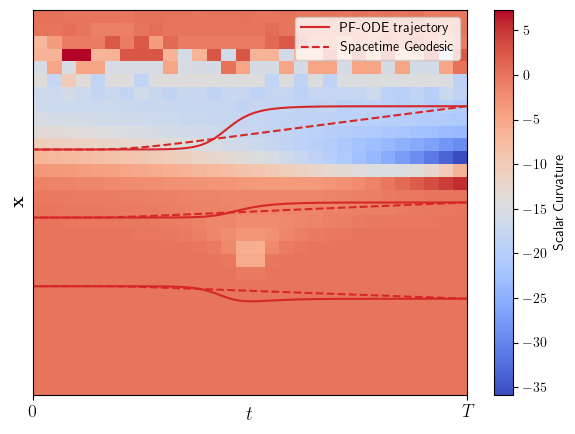

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

original_means = torch.tensor([0, 0.25, -0.5], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.4, dtype=torch.float32) #0.4
weights = torch.tensor([1, 1, 1], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -20, 20 #min/max logSNR values #-20,20

# Grid definition
t_min, t_max = 0.1, 1.0
x_min, x_max = -1, 1
n_t, n_x = 30, 30

t_vals = torch.linspace(t_min, t_max, n_t)
x_vals = torch.linspace(x_min, x_max, n_x)

T, X = torch.meshgrid(t_vals, x_vals, indexing="ij")  # Shape: (n_t, n_x)
R_vals = torch.zeros_like(T)

# Compute scalar curvature on grid
for i in range(n_t):
    for j in range(n_x):
        theta = torch.tensor([X[i, j].item(), T[i, j].item()], dtype=torch.float32)
        try:
            R_vals[i, j] = curvature_S(theta)
        except Exception as e:
            R_vals[i, j] = float("nan")  # skip invalid points
print(R_vals.detach().numpy())

R_vals=R_vals.detach().numpy()
# Plot heatmap + trajectories
fig, ax = plt.subplots(figsize=(7, 5))

# Heatmap
im = ax.imshow(
    R_vals, origin="lower", extent=(t_min, t_max, x_min, x_max),
    aspect="auto", cmap="coolwarm"
)
fig.colorbar(im, ax=ax, label="Scalar Curvature")

# Overlay trajectories (your existing loop)
for i, x in enumerate(torch.tensor([[-0.5], [0.], [0.5]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)

    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)

ax.legend()
ax.set_xlim((t_min, t_max))
ax.set_xticks([t_min, t_max], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
plt.show()


In [ ]:
def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t

gaussian_mixture_density(torch.tensor([[0.9]]), torch.tensor([[0.9]]))

tensor([[-1.3239,    -inf,    -inf]])

In [ ]:
import torch

_eps = 1e-12

def fisher_metric_from_nu_mu(theta, nu, mu):
    """
    Compute I_theta = (d nu / d theta)^T (d mu / d theta) for each theta.
    Ensures numeric symmetry by averaging I and I^T.

    Parameters
    ----------
    theta : torch.Tensor
        shape (2,) or (N,2) with ordering theta = [x_t, t] (or whatever ordering you use).
    nu : callable
        function nu(theta_batch) -> tuple/tensor of two components (both of shape (N,) or (N,1))
    mu : callable
        function mu(theta_batch) -> tuple/tensor of two components

    Returns
    -------
    I : torch.Tensor
        shape (2,2) for single point input, or (N,2,2) for batch input. Symmetric.
    """
    single = False
    if theta.ndim == 1:
        theta = theta.unsqueeze(0)  # (1,2)
        single = True
    N = theta.shape[0]
    device = theta.device
    dtype = theta.dtype

    I_all = torch.zeros((N, 2, 2), device=device, dtype=dtype)

    for i in range(N):
        # Work pointwise to avoid cross-batch gradient mixing
        th = theta[i:i+1].clone().requires_grad_(True)  # shape (1,2)

        # Evaluate nu and mu at this single point (expect outputs shaped (1,) each)
        nu_vals = nu(th)   # expected: tuple(tensor(N,)) or tensor (N,2)
        mu_vals = mu(th)

        # Normalize shapes: get two scalars as 1D tensors length 2
        # handles both return types: tuple of (comp1, comp2) or tensor (N,2)
        def _unpack_out(out):
            if isinstance(out, tuple) or isinstance(out, list):
                a = out[0].view(-1)
                b = out[1].view(-1)
                return torch.stack([a, b], dim=0)  # (2,1) -> (2,)
            else:
                # assume tensor shape (N,2)
                return out.view(-1, out.shape[-1]).T[:, 0] if out.ndim == 2 else out
        # Simpler: convert to a length-2 1D tensor for every output
        # We'll handle common cases explicitly:
        if isinstance(nu_vals, (tuple, list)):
            nu_vec = torch.stack([nu_vals[0].view(-1)[0], nu_vals[1].view(-1)[0]], dim=0)  # (2,)
        else:
            # nu_vals is tensor shape (1,2) or (1,2)
            nu_vals = nu_vals.view(1, -1)
            nu_vec = nu_vals[0]

        if isinstance(mu_vals, (tuple, list)):
            mu_vec = torch.stack([mu_vals[0].view(-1)[0], mu_vals[1].view(-1)[0]], dim=0)  # (2,)
        else:
            mu_vals = mu_vals.view(1, -1)
            mu_vec = mu_vals[0]

        # Build Jacobians J_nu and J_mu (2 x 2)
        J_nu = torch.zeros((2, 2), device=device, dtype=dtype)
        J_mu  = torch.zeros((2, 2), device=device, dtype=dtype)

        for j in range(2):
            # derivative of scalar nu_vec[j] w.r.t th -> shape (1,2), take [0]
            grad_nu = torch.autograd.grad(nu_vec[j], th, retain_graph=True, create_graph=True)[0]
            grad_mu = torch.autograd.grad(mu_vec[j],  th, retain_graph=True, create_graph=True)[0]

            # grad_* has shape (1,2) -> grab the single row
            J_nu[j, :] = grad_nu.view(-1)
            J_mu[j, :]  = grad_mu.view(-1)

        # I_point = J_nu^T @ J_mu
        I_point = J_nu.T @ J_mu

        I_all[i] = I_point

    return I_all[0] if single else I_all


original_means = torch.tensor([0, 0, 0], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1, 0, 0], dtype=torch.float32)  #1,0,0


LAMBDA_MIN, LAMBDA_MAX = -5, 5 #min/max logSNR values #-20,20
I_at_theta = fisher_metric_from_nu_mu(torch.tensor([-0.3, 0.6]), eta, mu)   # theta_point shape (2,)
print(I_at_theta)  # should be (2,2) symmetric


tensor([[  50.0760,  -26.9165],
        [ -26.9148, 2976.9648]], grad_fn=<SelectBackward0>)


In [ ]:
import torch
import torch

def scalar_curvature_2d(theta, nu, mu):
    """
    Computes the scalar curvature for a 2D metric defined by nu, mu.
    
    Parameters
    ----------
    theta : torch.Tensor of shape (2,)
        Coordinates: theta = [x_t, t].
    nu : callable
        Function nu(theta) returning a tuple/tensor of two components.
    mu : callable
        Function mu(theta) returning a tuple/tensor of two components.
    
    Returns
    -------
    R : scalar torch.Tensor
        Scalar curvature at theta.
    """
    theta = theta.clone().detach().requires_grad_(True)

    # Compute metric g_{ij}
    g = fisher_metric_from_nu_mu(theta, nu, mu)  # shape (2,2)

    det_g = torch.det(g)
    if det_g <= 0:
        raise ValueError("Metric determinant is non-positive, invalid metric.")

    sqrt_det_g = torch.sqrt(det_g)

    dg = torch.zeros(2, 2, 2, dtype=g.dtype, device=g.device)  # dg[k,i,j] = ∂g_{ij}/∂θ_k

    # Compute derivatives of g
    for i in range(2):
        for j in range(2):
            grad_output = torch.zeros_like(g)
            grad_output[i, j] = 1.0
            grad_g = torch.autograd.grad(g, theta,
                                          grad_outputs=grad_output,
                                          retain_graph=True,
                                          create_graph=True)[0]
            dg[:, i, j] = grad_g

    # Apply compact 2D scalar curvature formula:
    # R = (2 / sqrt(det(g))) * (
    #      ∂1((∂2 g_11 - ∂1 g_12) / sqrt(det(g))) +
    #      ∂2((∂1 g_22 - ∂2 g_12) / sqrt(det(g)))
    #     )

    term1 = (dg[1, 0, 0] - dg[0, 0, 1]) / sqrt_det_g
    term2 = (dg[0, 1, 1] - dg[1, 0, 1]) / sqrt_det_g

    dterm1 = torch.autograd.grad(term1, theta, create_graph=True)[0]
    dterm2 = torch.autograd.grad(term2, theta, create_graph=True)[0]

    R = (2.0 / sqrt_det_g) * (dterm1[0] + dterm2[1])
    return R

R = scalar_curvature_2d(torch.tensor([-0.6, 0.2], dtype=torch.float32), nu=eta, mu=mu)
print(R)


tensor(6.3211e-06, grad_fn=<MulBackward0>)


In [ ]:
import torch

import torch

def fisher_metric_xt_t(xt, t, nu_fn, mu_fn):
    """
    Compute the Fisher metric I_theta for given (x_t, t).

    Parameters
    ----------
    xt : torch.Tensor
        shape (N,) or scalar, the space component.
    t : torch.Tensor
        shape (N,) or scalar, the time component.
    nu_fn : callable
        function nu(theta_batch) -> tuple/tensor of two components.
    mu_fn : callable
        function mu(theta_batch) -> tuple/tensor of two components.

    Returns
    -------
    I : torch.Tensor
        shape (2,2) for scalar input, or (N,2,2) for batch input.
    """
    # Make sure xt and t are tensors
    xt = torch.as_tensor(xt, dtype=torch.float32)
    t = torch.as_tensor(t, dtype=torch.float32)

    # Prepare theta batch
    if xt.ndim == 0:
        theta = torch.stack([t, xt], dim=0).unsqueeze(0)  # (1,2)
    else:
        theta = torch.stack([t, xt], dim=-1)  # (N,2)

    N = theta.shape[0]
    device = theta.device
    dtype = theta.dtype

    I_all = torch.zeros((N, 2, 2), device=device, dtype=dtype)

    for i in range(N):
        th = theta[i:i+1].clone().detach().requires_grad_(True)  # (1,2)

        # Evaluate nu and mu at this single point
        nu_vals = nu_fn(th)
        mu_vals = mu_fn(th)

        # Unpack to length-2 tensors
        def unpack(vals):
            if isinstance(vals, (tuple, list)):
                return torch.stack([vals[0].view(-1)[0], vals[1].view(-1)[0]], dim=0)
            else:
                vals = vals.view(1, -1)
                return vals[0]

        nu_vec = unpack(nu_vals)
        mu_vec = unpack(mu_vals)

        J_nu = torch.zeros((2, 2), device=device, dtype=dtype)
        J_mu = torch.zeros((2, 2), device=device, dtype=dtype)

        for j in range(2):
            grad_nu = torch.autograd.grad(nu_vec[j], th, retain_graph=True, create_graph=True)[0]
            grad_mu = torch.autograd.grad(mu_vec[j], th, retain_graph=True, create_graph=True)[0]

            J_nu[j, :] = grad_nu.view(-1)
            J_mu[j, :] = grad_mu.view(-1)

        I_all[i] = J_nu.T @ J_mu

    return I_all[0] if xt.ndim == 0 else I_all

import torch

def curvature_2d(metric_fn, xt_val, t_val):
    xt = torch.tensor(xt_val, dtype=torch.float32, requires_grad=True)
    t = torch.tensor(t_val, dtype=torch.float32, requires_grad=True)

    # Compute metric at symbolic variables
    g = metric_fn(xt, t)  # shape (2,2)

    # Gradients helper
    def grad(f, var):
        return torch.autograd.grad(f, var, create_graph=True, allow_unused=True)[0]

    # Christoffel symbols
    g_inv = torch.inverse(g)
    dg_dx = torch.zeros((2, 2, 2))  # ∂g_ij / ∂x^k

    for i in range(2):
        for j in range(2):
            dg_dx[i, j, 0] = grad(g[i, j], xt)  # ∂/∂xt
            dg_dx[i, j, 1] = grad(g[i, j], t)   # ∂/∂t

    Gamma = torch.zeros((2, 2, 2))
    for k in range(2):
        for i in range(2):
            for j in range(2):
                Gamma[k, i, j] = 0.5 * sum(
                    g_inv[k, m] * (dg_dx[m, i, j] + dg_dx[m, j, i] - dg_dx[i, j, m])
                    for m in range(2)
                )

    # Curvature scalar formula for 2D (Gauss curvature)
    R = 0
    for i in range(2):
        for j in range(2):
            for k in range(2):
                R += g_inv[i, j] * (
                    grad(Gamma[k, i, j], xt if k == 0 else t)
                    - grad(Gamma[k, i, k], xt if j == 0 else t)
                    + sum(Gamma[l, i, j] * Gamma[k, l, k] - Gamma[l, i, k] * Gamma[k, l, j] for l in range(2))
                )
    return R.item()


def metric_fn_xt_t(xt, t):
    return fisher_metric_xt_t(xt, t, nu_fn=eta, mu_fn=mu)

R = curvature_2d(metric_fn_xt_t, torch.tensor(0.5), torch.tensor(1.0))
print("Scalar curvature:", R.item())


C:\Users\maria\AppData\Local\Temp\ipykernel_9316\2524341248.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xt = torch.tensor(xt_val, dtype=torch.float32, requires_grad=True)
C:\Users\maria\AppData\Local\Temp\ipykernel_9316\2524341248.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t_val, dtype=torch.float32, requires_grad=True)


TypeError: can't assign a NoneType to a torch.FloatTensor

In [ ]:
import torch
original_means = torch.tensor([0, 1, .1], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1, 0, 0], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -1, 1 #min/max logSNR values #-20,20

def scalar_curvature_gauss(metric_fn, theta, nu, mu, h=1e-5):
    g = metric_fn(theta, nu, mu)  # (2,2)
    det_g = torch.det(g)

    # Finite differences
    def d_g(idx):
        theta_plus = theta.clone().detach()
        theta_minus = theta.clone().detach()
        theta_plus[idx] += h
        theta_minus[idx] -= h
        return (metric_fn(theta_plus, nu, mu) - metric_fn(theta_minus, nu, mu)) / (2*h)  # (2,2)

    dg1 = d_g(0)  # ∂1 g
    dg2 = d_g(1)  # ∂2 g

    # Build the 3×3 determinant matrix
    det_matrix = torch.zeros((3,3), dtype=g.dtype, device=g.device)
    det_matrix[0,0] = g[0,0]
    det_matrix[0,1] = dg2[0,0]
    det_matrix[0,2] = dg1[0,0]

    det_matrix[1,0] = g[0,1]
    det_matrix[1,1] = dg2[0,1]
    det_matrix[1,2] = dg1[0,1]

    det_matrix[2,0] = g[1,1]
    det_matrix[2,1] = dg2[1,1]
    det_matrix[2,2] = dg1[1,1]

    det_det = torch.det(det_matrix)

    # Final curvature
    S = 1/4 * det_det / (det_g**2 + 1e-12)  # small eps to avoid div by zero
    return S


scalar_curvature_gauss(fisher_metric_from_nu_mu, torch.tensor([0.6, 0.4]), eta, mu)

tensor(-7.4143, grad_fn=<DivBackward0>)

In [ ]:
def curvature_S(theta):
    """
    Compute curvature S(theta) for either:
      - theta shape (2,)  single point
      - theta shape (N,2) batch of points

    Returns:
      tensor of shape (N,) for batch or scalar tensor for single point.
    """
    single = False
    if theta.ndim == 1:
        theta = theta.unsqueeze(0)  # (1,2)
        single = True
    N = theta.shape[0]
    device = theta.device
    dtype = theta.dtype

    S = torch.zeros(N, device=device, dtype=dtype)

    for i in range(N):
        # work pointwise to avoid cross-batch autodiff issues
        th = theta[i].clone().detach().requires_grad_(True)  # shape (2,)

        # compute metric g = Hessian(psi) at this point
        g = fisher_metric_from_nu_mu(torch.tensor([0.3, 0.2]), eta, mu)  # (2,2)

        # entries: g11 = g[0,0], g12 = g[0,1] (==g21), g22 = g[1,1]
        g11 = g[0, 0]
        g12 = g[0, 1]
        g22 = g[1, 1]

        # compute derivatives of each g_ij wrt theta = (x_t, t)
        # we need ∂1 g_ij and ∂2 g_ij. We'll compute grad(g_ij) which is shape (2,).
        dg11 = torch.autograd.grad(g11, th, retain_graph=True, create_graph=True)[0]  # [∂1 g11, ∂2 g11]
        dg12 = torch.autograd.grad(g12, th, retain_graph=True, create_graph=True)[0]  # [∂1 g12, ∂2 g12]
        dg22 = torch.autograd.grad(g22, th, retain_graph=True, create_graph=True)[0]  # [∂1 g22, ∂2 g22]

        # according to your formula, the 3x3 matrix rows are:
        # row1 = [ g11, ∂2 g11, ∂1 g11 ]
        # row2 = [ g12, ∂2 g12, ∂1 g12 ]
        # row3 = [ g22, ∂2 g22, ∂1 g22 ]
        # note: dgXX[0] = ∂1, dgXX[1] = ∂2
        mat3 = torch.zeros((3, 3), device=device, dtype=dtype)
        mat3[0, 0] = g11
        mat3[0, 1] = dg11[1]   # ∂2 g11
        mat3[0, 2] = dg11[0]   # ∂1 g11

        mat3[1, 0] = g12
        mat3[1, 1] = dg12[1]   # ∂2 g12
        mat3[1, 2] = dg12[0]   # ∂1 g12

        mat3[2, 0] = g22
        mat3[2, 1] = dg22[1]   # ∂2 g22
        mat3[2, 2] = dg22[0]   # ∂1 g22

        # numerator: determinant of the 3x3 matrix
        numerator = torch.det(mat3)

        # denominator: 4 * (det(g))^2 ; use small eps to avoid division by zero
        det_g = torch.det(g)
        denom = 4.0 * (det_g ** 2) + _eps

        S[i] = numerator / denom

    return S[0] if single else S

curvature_S(theta = torch.tensor([-0.3, 0.8], dtype=torch.float32)) 

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
import torch

def finite_diff_metric_derivative(metric_fn, theta, idx, nu, mu, h=1e-5):
    theta_plus = theta.clone().detach()
    theta_minus = theta.clone().detach()
    theta_plus[idx] += h
    theta_minus[idx] -= h

    g_plus = metric_fn(theta_plus, nu, mu)
    g_minus = metric_fn(theta_minus, nu, mu)

    return (g_plus - g_minus) / (2 * h)  # shape (2,2)

def christoffel_symbols(metric_fn, theta, nu, mu, h=1e-5):
    g = metric_fn(theta, nu, mu)             # (2,2)
    g_inv = torch.inverse(g)                 # (2,2)
    n = g.shape[0]
    Gamma = torch.zeros((n, n, n), dtype=g.dtype, device=g.device)

    for k in range(n):
        for i in range(n):
            for j in range(n):
                term = 0.0
                for l in range(n):
                    dg_jl = finite_diff_metric_derivative(metric_fn, theta, i, nu, mu)[j, l]
                    dg_il = finite_diff_metric_derivative(metric_fn, theta, j, nu, mu)[i, l]
                    dg_ij = finite_diff_metric_derivative(metric_fn, theta, l, nu, mu)[i, j]
                    term += g_inv[k, l] * (dg_jl + dg_il - dg_ij)
                Gamma[k, i, j] = 0.5 * term
    return Gamma

def scalar_curvature_2d(metric_fn, theta, nu, mu, h=1e-5):
    g = metric_fn(theta, nu, mu)
    g_inv = torch.inverse(g)
    n = g.shape[0]
    Gamma = christoffel_symbols(metric_fn, theta, nu, mu, h)

    # Riemann tensor in 2D: R^l_{ijk}
    R = torch.zeros((n, n, n, n), dtype=g.dtype, device=g.device)
    for l in range(n):
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    term1 = finite_diff_christoffel(Gamma, theta, j, l, i, metric_fn, nu, mu, h)[k]
                    term2 = finite_diff_christoffel(Gamma, theta, i, l, j, metric_fn, nu, mu, h)[k]
                    term3 = sum(Gamma[l,i,m] * Gamma[m,j,k] - Gamma[l,j,m] * Gamma[m,i,k] for m in range(n))
                    R[l,i,j,k] = term1 - term2 + term3

    # Ricci tensor: R_ij = R^k_{ikj}
    Ricci = torch.zeros((n,n), dtype=g.dtype, device=g.device)
    for i in range(n):
        for j in range(n):
            Ricci[i,j] = sum(R[k,i,k,j] for k in range(n))

    # Scalar curvature: R = g^ij R_ij
    return torch.sum(g_inv * Ricci)

def finite_diff_christoffel(Gamma, theta, var_idx, l, i, metric_fn, nu, mu, h=1e-5):
    theta_plus = theta.clone().detach()
    theta_minus = theta.clone().detach()
    theta_plus[var_idx] += h
    theta_minus[var_idx] -= h
    Gamma_plus = christoffel_symbols(metric_fn, theta_plus, nu, mu, h)
    Gamma_minus = christoffel_symbols(metric_fn, theta_minus, nu, mu, h)
    return (Gamma_plus[l,i,:] - Gamma_minus[l,i,:]) / (2*h)

  # (2,2)

scalar_curvature_2d(fisher_metric_from_nu_mu, torch.tensor([0.3, 0.2]), eta, mu)

tensor(38229.1523, grad_fn=<SumBackward0>)

In [ ]:
import torch


def scalar_curvature_2d(theta, metric_fn):
    th = theta.clone().detach().requires_grad_(True)
    g = metric_fn(th)  # shape (2,2)
    
    E, F, G = g[0,0], g[0,1], g[1,1]
    det_g = E*G - F**2
    sqrt_det_g = torch.sqrt(det_g + 1e-12)

    def partial(expr, var_idx):
        grad = torch.autograd.grad(expr, th, create_graph=True, allow_unused=True)[0]
        if grad is None:
            return torch.zeros_like(th[var_idx])
        return grad[var_idx]

    # First derivatives of metric components
    dE_dx, dE_dy = partial(E, 0), partial(E, 1)
    dF_dx, dF_dy = partial(F, 0), partial(F, 1)
    dG_dx, dG_dy = partial(G, 0), partial(G, 1)

    A = (dG_dx - dF_dy) / sqrt_det_g
    B = (dE_dy - dF_dx) / sqrt_det_g

    # Second derivatives
    dA_dx = partial(A, 0)
    dB_dy = partial(B, 1)

    K = -0.5 / sqrt_det_g * (dA_dx + dB_dy)
    return K



def fisher_rao_metric(theta):
    return fisher_metric_from_nu_mu(theta, eta, mu)  # (2,2)

theta = torch.tensor([0.2, 0.3], requires_grad=True)
curvature = scalar_curvature_2d(theta, fisher_rao_metric)
print("Scalar curvature:", curvature.item())


Scalar curvature: -0.0


In [ ]:
import torch
def safe_grad(val, th):
    grad = torch.autograd.grad(val, th, retain_graph=True, create_graph=True, allow_unused=True)[0]
    if grad is None:
        return torch.zeros_like(th)  # if independent of theta
    return grad


def christoffel_symbols(theta, metric_fn):
    """
    Compute Christoffel symbols Γ^k_ij at point theta.

    Parameters
    ----------
    theta : torch.Tensor
        Shape (2,), the coordinates (t, x).
    metric_fn : callable
        Function mapping theta -> g (2x2 symmetric metric tensor).

    Returns
    -------
    Gamma : torch.Tensor
        Shape (2, 2, 2), where Gamma[k,i,j] = Γ^k_{ij}.
    """
    th = theta.clone().detach().requires_grad_(True)
    g = metric_fn(th)  # (2,2)
    g_inv = torch.inverse(g)

    Gamma = torch.zeros((2, 2, 2), dtype=theta.dtype, device=theta.device)

    for i in range(2):
        for j in range(2):
            for k in range(2):
                # Christoffel symbol formula
                val = 0
                for l in range(2):
                    dg_lj = torch.autograd.grad(g[l, j], th, retain_graph=True, create_graph=True, allow_unused=True)[0]
                    dg_il = torch.autograd.grad(g[i, l], th, retain_graph=True, create_graph=True, allow_unused=True)[0]
                    dg_ij = torch.autograd.grad(g[i, j], th, retain_graph=True, create_graph=True, allow_unused=True)[0]
                    dg_lj = safe_grad(g[l, j], th)[i]
                    dg_il = safe_grad(g[i, l], th)[j]
                    dg_ij = safe_grad(g[i, j], th)[l]


                    val += g_inv[k, l] * (dg_lj + dg_il - dg_ij)
                Gamma[k, i, j] = 0.5 * val
    return Gamma


def curvature_scalar(theta, metric_fn):
    """
    Compute scalar curvature S(theta) for a 2D Riemannian metric.

    Parameters
    ----------
    theta : torch.Tensor
        Shape (2,), coordinates.
    metric_fn : callable
        Function mapping theta -> g (2x2 symmetric metric tensor).

    Returns
    -------
    S : torch.Tensor
        Scalar curvature at theta.
    """
    th = theta.clone().detach().requires_grad_(True)
    g = metric_fn(th)          # (2,2)
    g_inv = torch.inverse(g)
    Gamma = christoffel_symbols(th, metric_fn)

    # Compute Riemann tensor: R^l_{ijk}
    R = torch.zeros((2, 2, 2, 2), dtype=th.dtype, device=th.device)
    for l in range(2):
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    # d_j Γ^l_{ik}
                    dGamma_j = torch.autograd.grad(Gamma[l, i, k], th, retain_graph=True, create_graph=True)[0][j]
                    # d_k Γ^l_{ij}
                    dGamma_k = torch.autograd.grad(Gamma[l, i, j], th, retain_graph=True, create_graph=True)[0][k]
                    term = dGamma_j - dGamma_k
                    for m in range(2):
                        term += Gamma[l, j, m] * Gamma[m, i, k] - Gamma[l, k, m] * Gamma[m, i, j]
                    R[l, i, j, k] = term

    # Ricci tensor: R_ij = R^k_{ikj}
    Ric = torch.zeros((2, 2), dtype=th.dtype, device=th.device)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                Ric[i, j] += R[k, i, k, j]

    # Scalar curvature: S = g^{ij} R_ij
    S = 0
    for i in range(2):
        for j in range(2):
            S += g_inv[i, j] * Ric[i, j]
    return S

theta = torch.tensor([0.3, 0.5])
# Example: use your Fisher-Rao metric (from nu, mu)

def fisher_rao_metric(theta):
    return fisher_metric_from_nu_mu(theta, eta, mu)  # (2,2)


# Test
print("Curvature at theta:", curvature_scalar(theta, fisher_rao_metric).item())


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

## Code

100%|██████████| 200/200 [00:06<00:00, 30.70it/s]


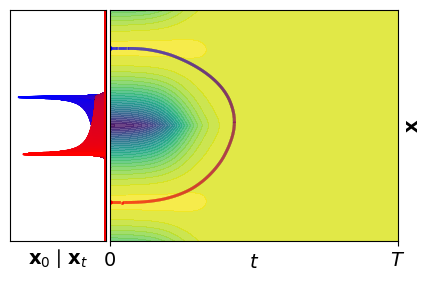

In [5]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm


theta1 = torch.tensor([0.001, 1]) #(theta=(t, x))
theta2 = torch.tensor([0.001, -1])

num_discretization_points = 10000
num_optimization_steps = 200

original_means = torch.tensor([-1, 1, 0], dtype=torch.float32)
original_variance = torch.tensor(0.004, dtype=torch.float32)
weights = torch.tensor([1/2,1/2, 0], dtype=torch.float32)

LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values #-20,20


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points, num_nodes=200)

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def get_means_and_variances(t, x):
    """
    When the data distribution p0 is a Gaussian mixture, then for every (t, xt), the `denoising distribution` (Eq 15 in the paper) is also a Gaussian Mixture. This function calculates the means and std of the denoising distribution in our Gaussian Mixture toy example. This function is used only to visualize the transition of densities in Figure 1.
    """
    alpha, sigma = alpha_sigma(t)
    snr = log_SNR(t).exp()
    variance_inv = 1 / original_variance + snr
    variance = 1 / variance_inv
    means = original_means/original_variance + alpha/sigma ** 2 * x
    return (means * variance).numpy(), variance.numpy()


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)

100%|██████████| 1000/1000 [00:03<00:00, 301.77it/s]


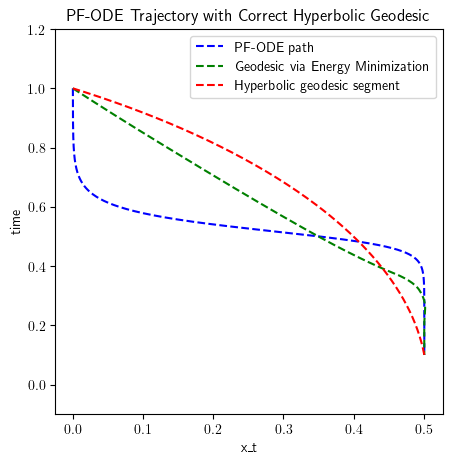

In [ ]:

original_means = torch.tensor([0.5, 0, 0], dtype=torch.float32)
original_variance = torch.tensor(0.4, dtype=torch.float32)
weights = torch.tensor([1, 0, 0], dtype=torch.float32)

LAMBDA_MIN, LAMBDA_MAX = -20, 20 #min/max logSNR values

x0 = torch.tensor([0.]) 
pf_ode_sample = sample(x0, 512, t_start=1., t_end=t_min)
pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))

# swap axes: horizontal = pf_ode_theta[:,1], vertical = pf_ode_theta[:,0]
theta1 = pf_ode_theta[0].numpy()
theta2 = pf_ode_theta[-1].numpy()

x1, y1 = theta1[1], theta1[0]  # horizontal, vertical
x2, y2 = theta2[1], theta2[0]

plt.figure(figsize=(5, 5))

# PF-ODE path with swapped axes
plt.plot(pf_ode_theta[:, 1], pf_ode_theta[:, 0],
         color='blue', linestyle='--', label='PF-ODE path')

# geodesic via energy minimization (also swap axes)
shortest_path12 = geodesic(pf_ode_theta[0], pf_ode_theta[-1],
                           n_opt_steps=1000, num_intermediate_points=128, num_nodes=10)
plt.plot(shortest_path12[:, 1], shortest_path12[:, 0],
         color='green', linestyle='--', label='Geodesic via Energy Minimization')

# analytic hyperbolic geodesic
if np.isclose(x1, x2):  # vertical geodesic
    plt.plot([x1, x2], [y1, y2], 'r--', label='Hyperbolic geodesic segment')
else:
    # center on x-axis
    c = (x1**2 + y1**2 - x2**2 - y2**2) / (2 * (x1 - x2))
    r = np.sqrt((x1 - c)**2 + y1**2)

    # angles for the arc
    angle1 = np.arctan2(y1, x1 - c)
    angle2 = np.arctan2(y2, x2 - c)
    if angle2 < angle1:
        angle1, angle2 = angle2, angle1  # ensure increasing order

    theta = np.linspace(angle1, angle2, 200)
    x_geo = c + r * np.cos(theta)
    y_geo = r * np.sin(theta)

    plt.plot(x_geo, y_geo, 'r--', label='Hyperbolic geodesic segment')

plt.xlabel('x_t')
plt.ylabel('time')
plt.title('PF-ODE Trajectory with Correct Hyperbolic Geodesic')
plt.ylim(min(y1, y2) - 0.2, max(y1, y2) + 0.2)
plt.legend()
plt.show()

Energy of pf ode trajectory: 0.013240760192275047 

100%|██████████| 1000/1000 [00:03<00:00, 311.07it/s]


Energy of a geodesic: 0.04581723362207413
Energy of pf ode trajectory: 0.04442765936255455 

100%|██████████| 1000/1000 [00:03<00:00, 307.89it/s]


Energy of a geodesic: 0.0941871926188469
Energy of pf ode trajectory: 0.022054746747016907 

100%|██████████| 1000/1000 [00:05<00:00, 174.45it/s]


Energy of a geodesic: 0.06424721330404282


Text(0, 0.5, '$\\mathbf{x}$')

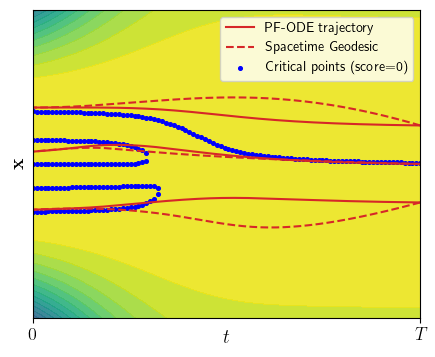

In [28]:
from curves import CubicSpline
import tqdm
from scipy.optimize import root_scalar

original_means = torch.tensor([ 0, -1.25, 0, 1.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
weights = torch.tensor([0, 1/4, 1/4, 1/4, 1/4], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5 #min/max logSNR values #-20,20

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

for i, x in enumerate(torch.tensor([[1.], [0.], [-1]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)

# Collect fixed point paths
t_vals = np.linspace(t_min, 1.0, 100)
fixed_points = []

for t in t_vals:
    roots = find_fixed_points(t)
    for r in roots:
        fixed_points.append((t, r))

fixed_points = np.array(fixed_points)

ax.scatter(fixed_points[:, 0], fixed_points[:, 1], color='blue', s=7, label="Critical points (score=0)")
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)

Energy of pf ode trajectory: 0.017142988741397858 

100%|██████████| 1000/1000 [00:03<00:00, 262.92it/s]


Energy of a geodesic: 0.043684519827365875
Energy of pf ode trajectory: 0.01375431939959526 

100%|██████████| 1000/1000 [00:04<00:00, 211.54it/s]


Energy of a geodesic: 0.030688390135765076
Energy of pf ode trajectory: 0.01841871440410614 

100%|██████████| 1000/1000 [00:05<00:00, 189.30it/s]


Energy of a geodesic: 0.04998020827770233


Text(0, 0.5, '$\\mathbf{x}$')

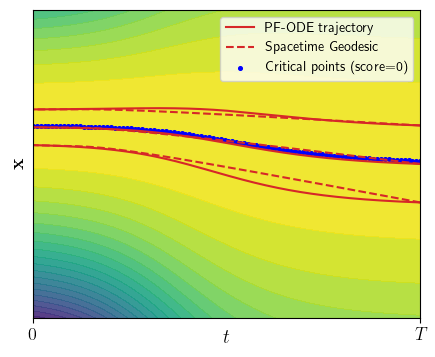

In [ ]:
#Gaussian to Gaussian Hyperbolic case: 

original_means = torch.tensor([1,0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([1,0], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5 #min/max logSNR values #-20,20
fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

for i, x in enumerate(torch.tensor([[1.], [0.], [-1]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)

# Collect fixed point paths
t_vals = np.linspace(t_min, 1.0, 100)
fixed_points = []

for t in t_vals:
    roots = find_fixed_points(t)
    for r in roots:
        fixed_points.append((t, r))

fixed_points = np.array(fixed_points)

ax.scatter(fixed_points[:, 0], fixed_points[:, 1], color='blue', s=7, label="Critical points (score=0)")
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)

Energy of pf ode trajectory: 0.02274937927722931 

100%|██████████| 1000/1000 [00:03<00:00, 291.63it/s]


Energy of a geodesic: 0.06650689989328384
Energy of pf ode trajectory: 0.022949347272515297 

100%|██████████| 1000/1000 [00:03<00:00, 297.74it/s]


Energy of a geodesic: 0.05520880967378616
Energy of pf ode trajectory: 0.02274937927722931 

100%|██████████| 1000/1000 [00:03<00:00, 296.43it/s]


Energy of a geodesic: 0.06650689989328384


Text(0, 0.5, '$\\mathbf{x}$')

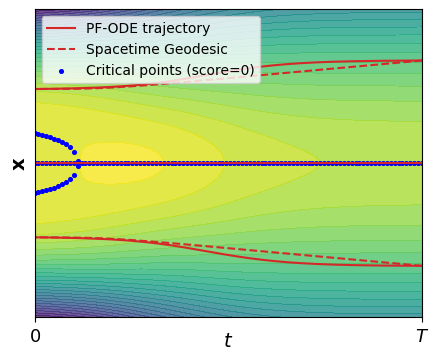

In [3]:
#Mixture of 2 Gaussians

original_means = torch.tensor([-0.5,0.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.2, dtype=torch.float32) #0.4
weights = torch.tensor([0.5,0.5], dtype=torch.float32)  #1,0,0 #1,1,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5 #min/max logSNR values #-20,20


fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

for i, x in enumerate(torch.tensor([[1.], [0.], [-1]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)

# Collect fixed point paths
t_vals = np.linspace(t_min, 1.0, 100)
fixed_points = []

for t in t_vals:
    roots = find_fixed_points(t)
    for r in roots:
        fixed_points.append((t, r))

fixed_points = np.array(fixed_points)

ax.scatter(fixed_points[:, 0], fixed_points[:, 1], color='blue', s=7, label="Critical points (score=0)")
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)

Energy of pf ode trajectory: 0.02874428778886795 theta1 tensor([1., 1.])
theta2 tensor([0.1000, 1.2947])


100%|██████████| 1000/1000 [00:03<00:00, 285.71it/s]


Energy of a geodesic: 0.09323237091302872
Energy of pf ode trajectory: 0.03918280452489853 theta1 tensor([1., 0.])
theta2 tensor([0.1000, 0.0000])


100%|██████████| 1000/1000 [00:03<00:00, 279.49it/s]


Energy of a geodesic: 0.1080833226442337
Energy of pf ode trajectory: 0.02874428778886795 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -1.2947])


100%|██████████| 1000/1000 [00:04<00:00, 242.71it/s]

Energy of a geodesic: 0.09323237091302872


Text(0, 0.5, '$\\mathbf{x}$')

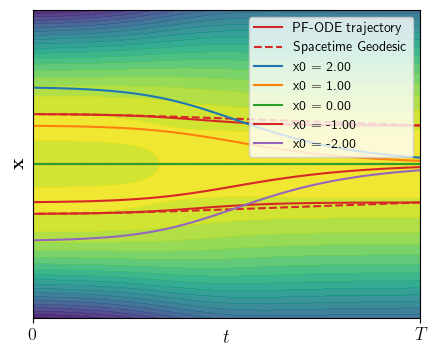

In [ ]:
import numpy as np
import torch
from curves import CubicSpline
import tqdm
from scipy.optimize import root_scalar


def critical_point_path(x0, t_vals):
    """
    Compute the path of critical points of ∇_{xt} log p(x0 | xt).
    Since score=0 ⇒ xt = alpha_t * x0.
    
    Parameters
    ----------
    x0 : float
        The given initial x0.
    t_vals : array-like
        Times in [0,1].
    
    Returns
    -------
    fixed_points : np.ndarray of shape (len(t_vals), 2)
        Array of (t, xt) pairs tracing the critical point path.
    """
    t_tensor = torch.tensor(t_vals, dtype=torch.float32)
    alpha_t, _ = alpha_sigma(t_tensor)
    xt_path = (alpha_t * x0).numpy()
    return np.stack([t_vals, xt_path], axis=1)

original_means = torch.tensor([-1, 1, 0], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.4, dtype=torch.float32) #0.4
weights = torch.tensor([1, 1, 0], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -5, 5 #min/max logSNR values #-20,20

# SDE parameters

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

for i, x in enumerate(torch.tensor([[1.], [0.], [-1]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    print('theta1', theta1)
    print('theta2', theta2)
    #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
    #theta2 = torch.tensor([0.9999, 3.5])
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)




# Example usage with multiple x0 values
t_vals = np.linspace(t_min, 1.0, 100)
x0_list = [2, 1, 0, -1, -2]   # <-- pick any set of fixed points

for x0 in x0_list:
    fixed_points = critical_point_path(x0=x0, t_vals=t_vals)
    ax.plot(fixed_points[:, 0], fixed_points[:, 1],
            label=f"x0 = {x0:.2f}")

# --- plotting section ---
ax.legend()


ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)

Energy of pf ode trajectory: 0.12187743186950684 

100%|██████████| 2000/2000 [00:11<00:00, 180.91it/s]


Energy of a geodesic: 0.08070765435695648
Energy of pf ode trajectory: 0.11296321451663971 

100%|██████████| 2000/2000 [00:13<00:00, 148.59it/s]

Energy of a geodesic: 0.07235174626111984


Text(0, 0.5, '$\\mathbf{x}$')

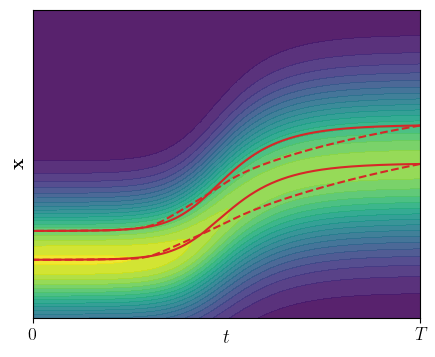

In [ ]:



fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)
for i, x in enumerate(torch.tensor([[1.], [0.]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=2000, num_intermediate_points=512, num_nodes=10)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)


Energy of pf ode trajectory: 0.14768564701080322 

100%|██████████| 1000/1000 [00:03<00:00, 322.12it/s]


Energy of a geodesic: 0.4083717167377472
Energy of pf ode trajectory: 0.1404285430908203 

100%|██████████| 1000/1000 [00:03<00:00, 332.05it/s]


Energy of a geodesic: 0.348026305437088
Energy of pf ode trajectory: 0.15019121766090393 

100%|██████████| 1000/1000 [00:03<00:00, 331.43it/s]

Energy of a geodesic: 0.42191436886787415


Text(0, 0.5, '$\\mathbf{x}$')

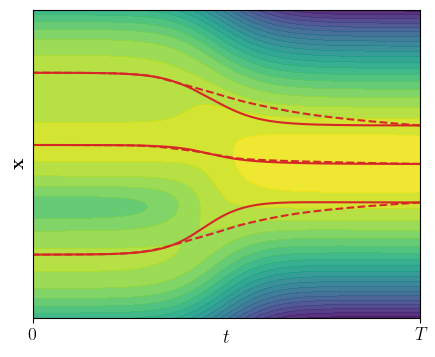

In [ ]:
original_means = torch.tensor([-2.5, 0.5, 2.5], dtype=torch.float32)
original_variance = torch.tensor(0.75 ** 2, dtype=torch.float32)
weights = torch.tensor([0.275, 0.45, 0.275], dtype=torch.float32)

# SDE parameters

LAMBDA_MIN, LAMBDA_MAX = -10, 10 #min/max logSNR values

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

for i, x in enumerate(torch.tensor([[1.], [0.], [-1]])):
    pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]

    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=10)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
    ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)